# Implement heuristic algorithm

In [1]:
import os
import io
import random
import fnmatch
from csv import DictWriter
import pandas as pd

import pdb

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from deap import base, creator, tools
import math


1 Name: Mavrovouniotis Menelaou Instances Test: 1 

2 COMMENT: Modificatification of E-n22-k4 instance. Modified by Mavrovouniotis Menelaou.

3 TYPE: EVRP 

4 OPTIMAL_VALUE: 384.678035 

5 VEHICLES: 4 

6 DIMENSION: 22 

7 STATIONS: 8 

8 CAPACITY: 6000 

9 ENERGY_CAPACITY: 94 

10 ENERGY_CONSUMPTION: 1.20 

11 EDGE_WEIGHT_FORMAT: EUC_2D

12 NODE_COORD_SECTION 

13 1 145 215 

14 2 151 264 

15 3 159 261 

16 4 130 254 

17 5 128 252 

18 6 163 247 

19 7 146 246 

20 8 161 242 

21 9 142 239 

22 10 163 236 

23 11 148 232 

24 12 128 231 

25 13 156 217 

26 14 129 214 

27 15 146 208 

28 16 164 208 

29 17 141 206 

30 18 147 193 

31 19 164 193 

32 20 129 189 

33 21 155 185 

34 22 139 182 

35 23 137 193 

36 24 137 213 

37 25 137 234 

38 26 137 254 

39 27 155 193 

40 28 155 213 

41 29 155 234 

42 30 155 254 

43 DEMAND_SECTION 

44 1 0

45 2 1100

46 3 700

47 4 800

48 5 1400

49 6 2100

50 7 400

51 8 800

52 9 100

53 10 500

54 11 600

55 12 1200

56 13 1300

57 14 1

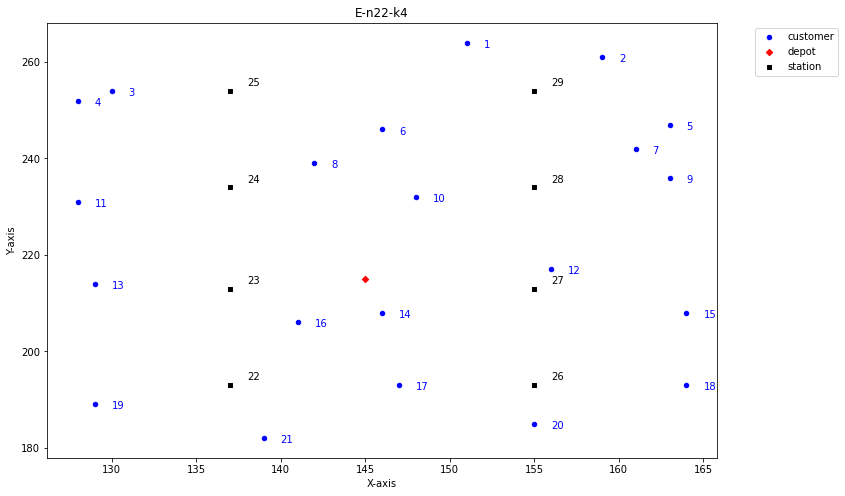

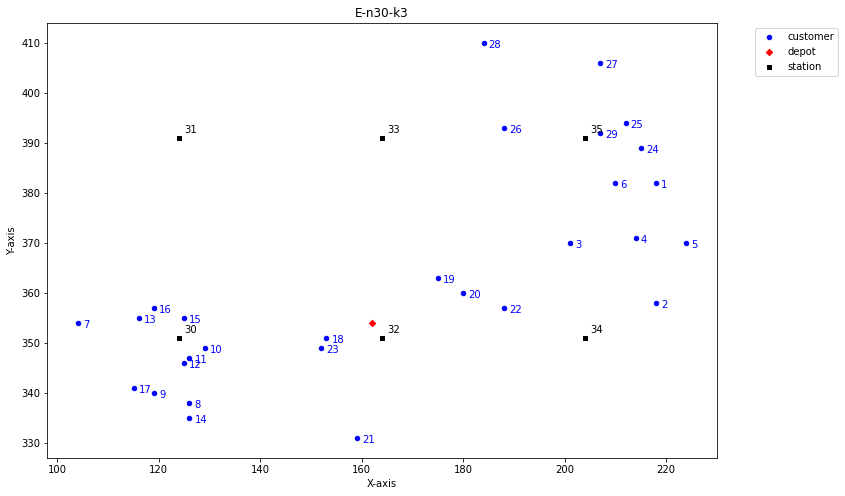

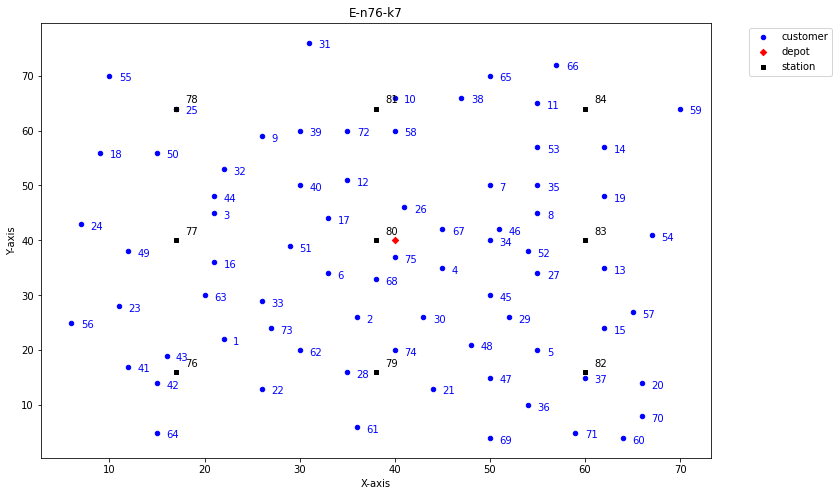

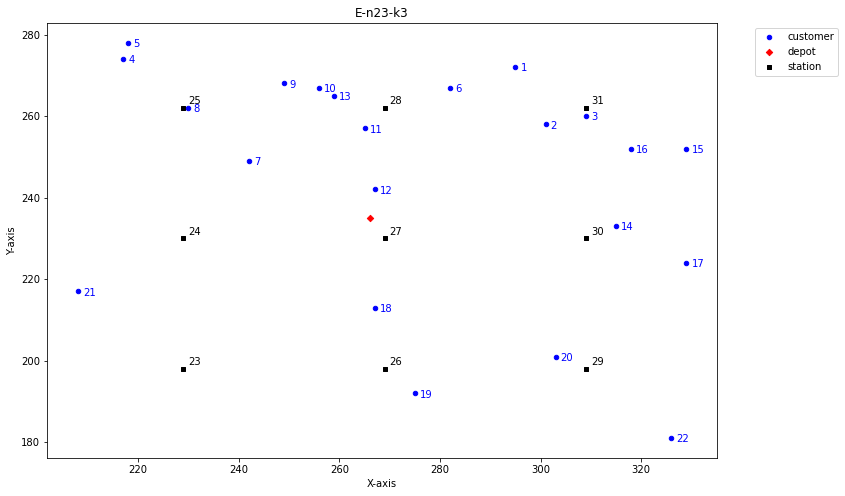

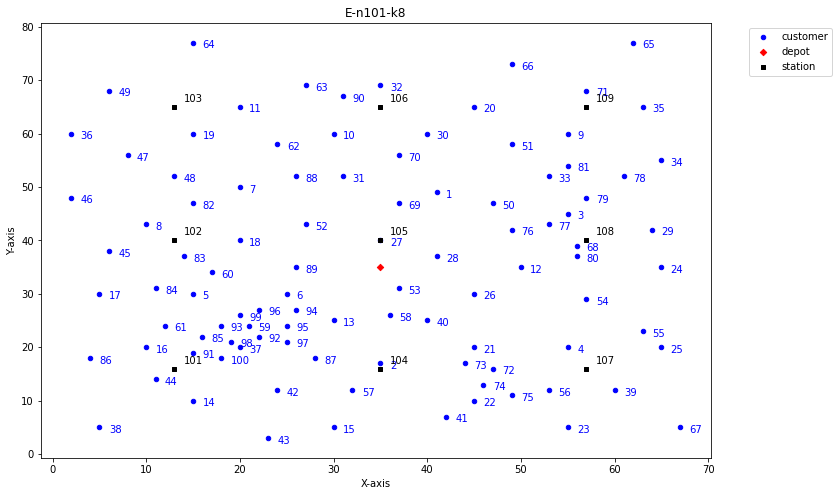

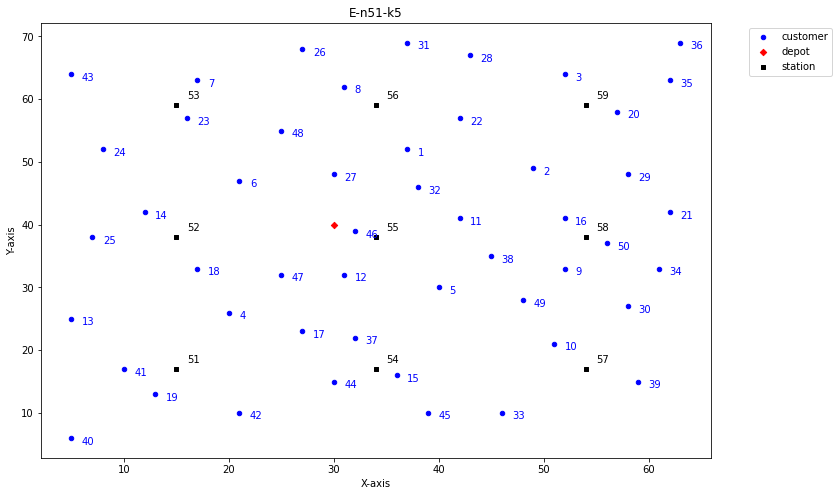

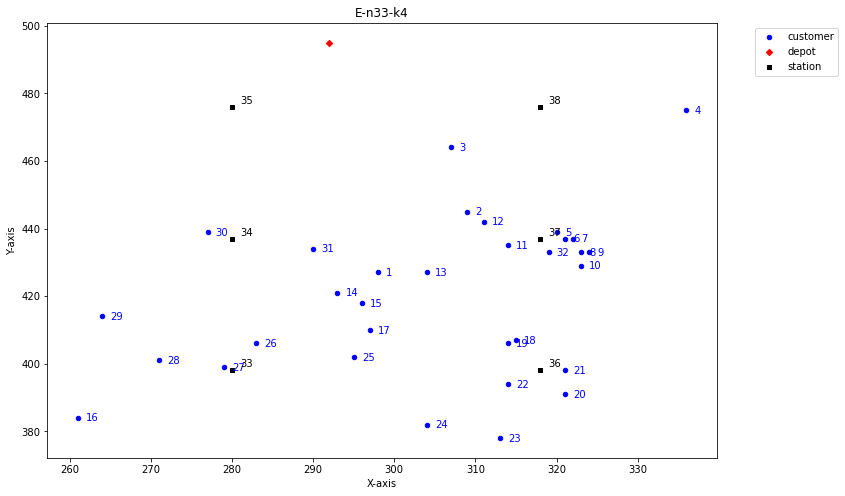

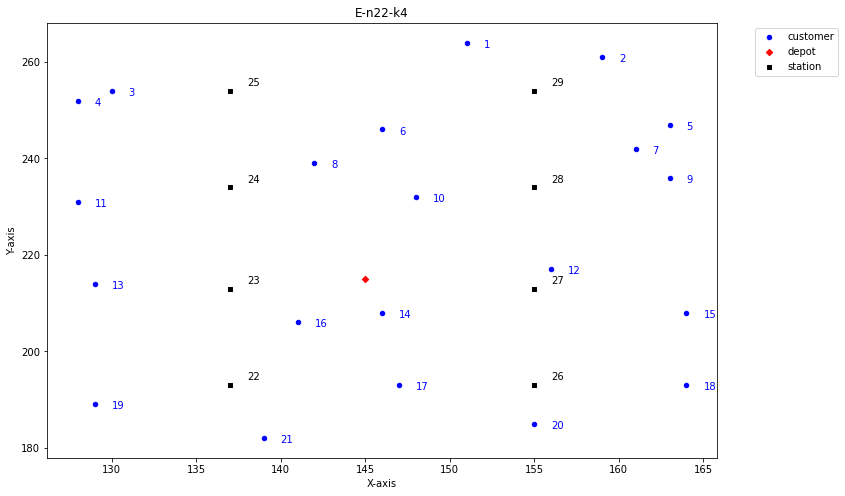

In [2]:
%run read_data.ipynb

In [3]:
BASE_DIR = os.path.abspath(os.path.dirname(os.path.dirname('.')))
data_dir = os.path.join(BASE_DIR, 'evrp-benchmark-set')
result_dir = os.path.join(BASE_DIR, 'results')

In [4]:
fnmatch.filter(os.listdir(data_dir), '*.evrp')

['X-n685-k75.evrp',
 'E-n30-k3.evrp',
 'X-n1001-k43.evrp',
 'X-n214-k11.evrp',
 'E-n76-k7.evrp',
 'X-n459-k26.evrp',
 'E-n23-k3.evrp',
 'X-n916-k207.evrp',
 'X-n749-k98.evrp',
 'X-n351-k40.evrp',
 'X-n819-k171.evrp',
 'E-n101-k8.evrp',
 'E-n51-k5.evrp',
 'E-n33-k4.evrp',
 'X-n573-k30.evrp',
 'E-n22-k4.evrp',
 'X-n143-k7.evrp']

## Requirements - standard output

* a solution format is required below:
  * the format of the solution is as follows:
  ```
    tour:  0 - 5 - 6 - 8 - 0 - 1 - 2 - 3 - 4 - 0 - 7 - 0
  ```
  * Route id:
  ```
  1 - 1 - 1 - 1 - 2 - 2 - 2 - 2 - 2 - 3 - 3 - 3
  ```
  * this solution consists of three routes: 
  ```
    Route 1: 0 - 5 - 6 - 8 - 0
    Route 2: 0 - 1 - 2 - 3 - 4 - 0
    Route 3: 0 - 7 - 0  
  ```

In [5]:
# instance.__dict__

### Note!

* Check whether the battery capacity of the vehicle can support to visit any customer node directly from depot in the graph - Yes
* Check whether there exist customer's demand is greater than the capacity of the vehicle - Yes

> The two assumptions above have been checked in the code below, and they are important for coding in the following function `individual_2_route(individual, instance)`.

In [5]:
for file_name in fnmatch.filter(os.listdir(data_dir), '*.evrp'):
    file_dir = os.path.join(data_dir, file_name)
    _instance = Benchmark_Instance(file_dir)
    for _ in range(1, _instance.actual_problem_size):
        if _instance.distance_matrix[0][_] * _instance.energy_consumption > _instance.battery_capacity:
            print("Find one customer node that the vehicle cannot reach directly from depot with the limit of battery capacity")
    for _ in range(1, _instance.dimension):
        if _instance.demands[f'{_}'] > _instance.capacity:
            print('Find one customer demand is greater than the capacity of the vehicle')
        

## GA Implementation
____

### Individual (Chromosome)


#### Individual encoding
* The individual is encoded into a integer list, for example, `[5, 3, 2, 7, 1, 6, 9, 8, 4]`, the number in the list denotes the customer node

#### Individual decoding
* The function - `individual_2_route(individual, instance)` - is the core part, which converts the individual (encoded as a list of integers) into a list of feasible routes. In other words, we will try let the individual feasible by inserting charging stations. An example is given below:

```python

# For the benchmark instance `E-n22-k4.evrp`, an individual is given
# depot: 0
# customer: 1, 2, ..., 21
# charging station: 22, 23, ..., 29

individual: [21, 18, 20, 12, 6, 10, 1, 15, 2, 17, 7, 11, 14, 8, 13, 16, 4, 9, 3, 19, 5]

route 0: 0-21-18-26-20-12-27-6-10-0
route 1: 0-1-29-15-27-2-29-17-26-7-28-11-14-0
route 2: 0-8-13-16-23-4-25-9-0
route 3: 0-3-25-19-22-5-29-0
```

* __NOTE__: The number of the generated routes might be greater than the given vehicle numbers. For example, only 4 EVs are given in the instance `E-n22-k4.evrp`, but the resulted individual is possible to have more than 4 EVs.

In [6]:
def find_nearest_station(node_no, distance_matrix, station_list):
    '''Fine the nearest charging station of the given node
    
    Args:
        node: the index of the node
        distance_matrix: the distance matrix of nodes
        staion_list: the list of station nodes 
    
    Returns:
        the index of the station
    '''
    return int(min(station_list, key=lambda station_no: distance_matrix[int(node_no)][int(station_no)])) 

def is_feasible(route, capacity_left, energy_left, distance_matrix, energy_consumption, station_list):
    '''Judge whether the sub route is feasible, i.e., 
    1. The capacity left is greater than or equal to 0
    2. The state of battery (SOC) left is greater than or equal to 0
    3. The SOC of the vihicle can support the vehicle to return the depot or visit the nearest charging station
    
    Args:
        route: the sub-route
        capacity_left: the capacity left of the vehicle
        energy_left: the energy left of the vehicle
        distance_matrix: the distance matrix of nodes
        energy_consumption: the energy consumption rate
        staion_list: the list of station nodes 
        
    Returns:
        boolean value
    '''
    current = route[-1]
    nearest_station = find_nearest_station(current, distance_matrix, station_list)
    depot = 0

    # Calculate the energy required to reach the nearest station or the depot
    energy_required = energy_consumption * min(distance_matrix[current][nearest_station], distance_matrix[current][depot])
    
    if capacity_left >= 0 and energy_left >= 0 and energy_left >= energy_required:
        return True
    else:
        return False

    

In [7]:
def handle_infeasible_route(route, sub_route, nearest_station, updated_capacity_left, updated_energy_left, energy_left, prev_node, node, MAX_CAPACITY, BATTERY_CAPACITY, DISTANCE_MATRIX, ENERGY_CONSUMPTION, STATION_LIST):
    '''Handle the infeasible sub-route, namely, try to repair it or end it.
    
    Args:
        route: a list of sub_routes
        sub_route: a list of integers (i.e., customer and station nodes)
        nearest_station: the nearest charging station for the end node in the current sub-route
        updated_capacity_left: the capacity left of the vehicle after appending the current node to the sub-route 
        updated_energy_left: the energy left of the vehicle after appending the current node to the sub-route 
        energy_left: currently, the energy left of the vehicle (i.e., haven't appending the current node to the sub-route)
        prev_node: the previous customer node beforing appending the current node, i.e., the end node of current sub-route
        node: the current customer node, which is the node we try to append it to the sub-route
        MAX_CAPACITY: the max capacity of the EV, constant
        BATTERY_CAPACITY: The state of battery (SOC) left of the EV, constant
        DISTANCE_MATRIX: the distance matrix of nodes, constant
        ENERGY_CONSUMPTION: the energy consumption rate, constant
        STATION_LIST: the list of station nodes, constant
    
    Returns:
        a dictionary - {'route': route, 'sub_route': sub_route, 'capacity_left': capacity_left, 
        'energy_left': energy_left, 'prev_node': prev_node, 'assigned': assigned}
    '''
    assigned = False
    if updated_capacity_left < 0:
        # Handle the case where vehicle capacity is exhausted
        if energy_left >= ENERGY_CONSUMPTION * DISTANCE_MATRIX[prev_node][0]:
            route.append(sub_route)
        else:
            sub_route.append(nearest_station)
            route.append(sub_route)
    else:
        # Handle the case where vehicle energy is insufficient
        if energy_left >= ENERGY_CONSUMPTION * max(DISTANCE_MATRIX[prev_node][nearest_station], DISTANCE_MATRIX[prev_node][0]):
            # Starting from the prev_node, the EV has enough battery to reach the nearest charging station and return to the depot.
            sub_route.append(nearest_station)
            if is_feasible(sub_route + [node], updated_capacity_left, updated_energy_left, DISTANCE_MATRIX, ENERGY_CONSUMPTION, STATION_LIST):
                sub_route.append(node)
                capacity_left = updated_capacity_left
                energy_left = updated_energy_left
                prev_node = node
                assigned = True
                return {'route': route, 'sub_route': sub_route, 'capacity_left': capacity_left, 'energy_left': energy_left, 'prev_node': prev_node, 'assigned': assigned}
            else:
                sub_route.pop()
                route.append(sub_route)
        elif energy_left >= ENERGY_CONSUMPTION * DISTANCE_MATRIX[prev_node][nearest_station]:
            # Starting from the prev_node, the EV doesn't have enough battery to return to the depot, but can reach the nearest charging station.
            sub_route.append(nearest_station)
            if is_feasible(sub_route + [node], updated_capacity_left, updated_energy_left, DISTANCE_MATRIX, ENERGY_CONSUMPTION, STATION_LIST):
                sub_route.append(node)
                capacity_left = updated_capacity_left
                energy_left = updated_energy_left
                prev_node = node
                assigned = True
                return {'route': route, 'sub_route': sub_route, 'capacity_left': capacity_left, 'energy_left': energy_left, 'prev_node': prev_node, 'assigned': assigned}
            else:
                route.append(sub_route)
        else:
            # Starting from the prev_node, the EV cannot reach the nearest station or return to the depot
            route.append(sub_route)
    
    sub_route = []
    capacity_left = MAX_CAPACITY
    energy_left = BATTERY_CAPACITY
    prev_node = 0
    
    return {'route': route, 'sub_route': sub_route, 'capacity_left': capacity_left, 'energy_left': energy_left, 'prev_node': prev_node, 'assigned': assigned}

In [8]:
def individual_2_route(individual, instance):
    '''Convert the individual (encoded as a list of integers) into a list of feasible routes.
    The individual is encoded as a list of customer nodes, and each feasible route is preceded by a vehicle.
    
    Args:
        individual: a list of integers (customer nodes)
        instance: the benchmark instance got from the original data
        
    Returns:
        routes - a list of feasible sub-routes (each sub-route might contain customer or station nodes)
    '''
    route = []

    # Retrieve necessary instance parameters
    MAX_CAPACITY = instance.capacity
    BATTERY_CAPACITY = instance.battery_capacity
    ENERGY_CONSUMPTION = instance.energy_consumption
    STATION_LIST = instance.station_list
    DISTANCE_MATRIX = instance.distance_matrix
    DEMANDS = instance.demands

    # Initialize a sub-route and related variables
    sub_route = []
    capacity_left = MAX_CAPACITY
    energy_left = BATTERY_CAPACITY
    prev_node = 0

    # Iterate through customer nodes and insert them into feasible sub-routes
    for node in individual:
        assigned = False
        while not assigned:
            # Calculate remaining capacity and energy after inserting the current customer node
            updated_capacity_left = capacity_left - DEMANDS[f'{node}']
            updated_energy_left = energy_left - ENERGY_CONSUMPTION * DISTANCE_MATRIX[prev_node][node]

            # Check if the updated route is feasible
            if is_feasible(sub_route + [node], updated_capacity_left, updated_energy_left, DISTANCE_MATRIX, ENERGY_CONSUMPTION, STATION_LIST):
                # Add the customer node to the sub-route and update related variables
                sub_route.append(node)
                capacity_left = updated_capacity_left
                energy_left = updated_energy_left
                prev_node = node
                assigned = True
            else:
                # Determine the reason for infeasibility and take appropriate action
                nearest_station = find_nearest_station(prev_node, DISTANCE_MATRIX, STATION_LIST)
                updated_energy_left = BATTERY_CAPACITY - ENERGY_CONSUMPTION * DISTANCE_MATRIX[nearest_station][node]

                result = handle_infeasible_route(route, sub_route, nearest_station, updated_capacity_left, 
                                                 updated_energy_left, energy_left, prev_node, node, MAX_CAPACITY, 
                                                 BATTERY_CAPACITY, DISTANCE_MATRIX, ENERGY_CONSUMPTION, STATION_LIST)
                route, sub_route, capacity_left, energy_left, prev_node, assigned = result.values()

    # Handle the remaining sub_route, if any
    if sub_route != []:
        if energy_left >= ENERGY_CONSUMPTION * DISTANCE_MATRIX[sub_route[-1]][0]:
            route.append(sub_route)
        else:                            
            nearest_station = find_nearest_station(sub_route[-1], DISTANCE_MATRIX, STATION_LIST)
            sub_route.append(nearest_station)
            route.append(sub_route)

    return route



#### Validate the generated route of the function `individual_2_route`

* Output the route info and the EV's energy and capacity change of in each sub-route 
* Visualize the route information 

In [9]:
def validate_generated_route_details(route, instance, is_detailed=True):
    '''Validate the results of the function individual_2_route, check the feasibility of them.
    The function will do two tasks: 1. print the details of the route; 2. if some unexcepted info appears, then Note it! 
    
    Args:
        route: the result from the function `individual_2_route`
        instance: the benchmark instance got from the original data
        is_detailed: whether print the detailed info
    '''
    MAX_CAPACITY = instance.capacity
    BATTERY_CAPACITY = instance.battery_capacity
    ENERGY_CONSUMPTION = instance.energy_consumption
    NUM_OF_VEHICLES = instance.num_of_vehicles
    STATION_LIST = instance.station_list
    DISTANCE_MATRIX = instance.distance_matrix
    DEMANDS = instance.demands
    
    delim = '-'
    
    for idx, sub_route in enumerate(route):
        
        sub_route = [0] + sub_route + [0]
        
        
        detailed_sub_route = []
        capacity_left_list = []
        energy_left_list   = []
        
        capacity_left = MAX_CAPACITY
        energy_left   = BATTERY_CAPACITY
        prev_node = 0
        
        for node in sub_route:
            if str(node) in STATION_LIST:
                energy_left = BATTERY_CAPACITY
                prev_node = node
                
                detailed_sub_route.append('{}({}, {:.2f})'.format(prev_node, capacity_left, energy_left))
                
                if capacity_left < 0 or energy_left < 0:
                    print('******NOTE*******  ', capacity_left, energy_left)
            else:
                capacity_left -= DEMANDS[f'{node}']
                energy_left -= ENERGY_CONSUMPTION * DISTANCE_MATRIX[prev_node][node]
                prev_node = node
                    
                detailed_sub_route.append('{}({}, {:.2f})'.format(prev_node, capacity_left, energy_left))
                
                if capacity_left < 0 or energy_left < 0:
                    print('******NOTE*******  ', capacity_left, energy_left)
                    
        if is_detailed == True:
            print(delim.join(map(str, detailed_sub_route)), end='\n\n')


* Check whether there are unexcepted data by randomly generating 100 individuals

In [10]:
# Check whether there are unexcepted data by randomly generating 100 individuals
for _ in range(100):
    random.seed(_)
    individual = list(range(1, instance.dimension))
    random.shuffle(individual)

    routes = individual_2_route(individual, instance)
    
#     print('Random Seed: ', _)
    validate_generated_route_details(routes, instance, is_detailed=False)

* Print the detailed route info and check it one-by-one

In [11]:
random.seed(2)

individual = list(range(1, instance.dimension))
random.shuffle(individual)
print(f'The randomly generated individual: \n{individual}', end='\n\n')

routes = individual_2_route(individual, instance)
print(f'The decoded route from the individual:\n{routes}', end='\n\n') 

validate_generated_route_details(routes, instance)

The randomly generated individual: 
[11, 21, 8, 9, 15, 13, 17, 7, 19, 18, 1, 14, 4, 16, 5, 10, 6, 12, 20, 3, 2]

The decoded route from the individual:
[[11, 24, 21, 22, 8, 9, 28, 15, 13, 23, 17], [7, 28, 19, 22, 18], [1, 29, 14, 23, 4, 25, 16], [5, 10, 28, 6, 12], [20, 26, 3, 25, 2]]

0(6000, 94.00)-11(4800, 65.99)-24(4800, 94.00)-21(4100, 31.55)-22(4100, 94.00)-8(4000, 38.47)-9(3500, 13.02)-28(3500, 94.00)-15(2600, 60.98)-13(1300, 18.37)-23(1300, 94.00)-17(300, 67.17)-0(300, 40.66)

0(6000, 94.00)-7(5200, 56.34)-28(5200, 94.00)-19(2700, 31.63)-22(2700, 94.00)-18(1800, 61.60)-0(1800, 26.72)

0(6000, 94.00)-1(4900, 34.76)-29(4900, 94.00)-14(4600, 37.75)-23(4600, 94.00)-4(3200, 45.97)-25(3200, 94.00)-16(1100, 36.20)-0(1100, 24.38)

0(6000, 94.00)-5(3900, 49.94)-10(3300, 24.49)-28(3300, 94.00)-6(2900, 76.00)-12(1600, 39.19)-0(1600, 25.77)

0(6000, 94.00)-20(4200, 56.05)-26(4200, 94.00)-3(3400, 14.89)-25(3400, 94.00)-2(2700, 66.30)-0(2700, 8.60)



#### Visualize the route plot

In [12]:
def plot_route(route, df, ax, route_color='green', linewidth=1):
    # Add the depot index (0) at the beginning and end of the route
    route_with_depot = [0] + route + [0]

    for i in range(len(route_with_depot) - 1):
        start_customer_idx = route_with_depot[i]
        end_customer_idx = route_with_depot[i + 1]

        x1, y1 = df['x_pos'].loc[start_customer_idx], df['y_pos'].loc[start_customer_idx]
        x2, y2 = df['x_pos'].loc[end_customer_idx], df['y_pos'].loc[end_customer_idx]

        ax.plot([x1, x2], [y1, y2], color=route_color, linewidth=linewidth)

def visualize_routes(routes, df, title='Route Plot'):
    colors = {'depot': 'red', 'customer': 'blue', 'station': 'black'}
    markers = {'depot': 'D', 'customer': 'o', 'station': 's'}

    fig, ax = plt.subplots(figsize=(12, 8))
    for label, group in df.groupby('label'):
        if label == 'depot':
            group.plot(kind='scatter', x='x_pos', y='y_pos', label=label, color=colors[label], marker=markers[label], ax=ax, s=30)
        elif label == 'customer':
            group.plot(kind='scatter', x='x_pos', y='y_pos', label=label, color=colors[label], marker=markers[label], ax=ax)
        else:  # For the 'station' label
            group.plot(kind='scatter', x='x_pos', y='y_pos', label=label, color=colors[label], marker=markers[label], ax=ax, s=30) 
            

        # Add node_no labels for customer nodes
        if label == 'customer':
            for index, row in group.iterrows():
                ax.text(row['x_pos'] + 1, row['y_pos'] - 1, str(row['node_no']), fontsize=10, color=colors[label])
        elif label == 'station':
            for index, row in group.iterrows():
                ax.text(row['x_pos'] + 1, row['y_pos'] + 1, str(row['node_no']), fontsize=10, color=colors[label])
    
    # Create a colormap and generate a list of colors for each route
    colormap = plt.cm.get_cmap('tab10', len(routes))
    colors = [mcolors.rgb2hex(colormap(i)[:3]) for i in range(len(routes))]

    for i, route in enumerate(routes):
        plot_route(route, df, ax, route_color=colors[i])
    
    
    ax.set_title(title)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')

    # Move the legend and show the plot inside the loop
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

[[21], [26, 28, 27, 35, 29, 25, 24, 1, 6, 19], [20, 3, 4, 5, 2, 22], [15, 16, 13, 7, 17, 9, 14, 8, 12, 11, 10, 23, 18]]


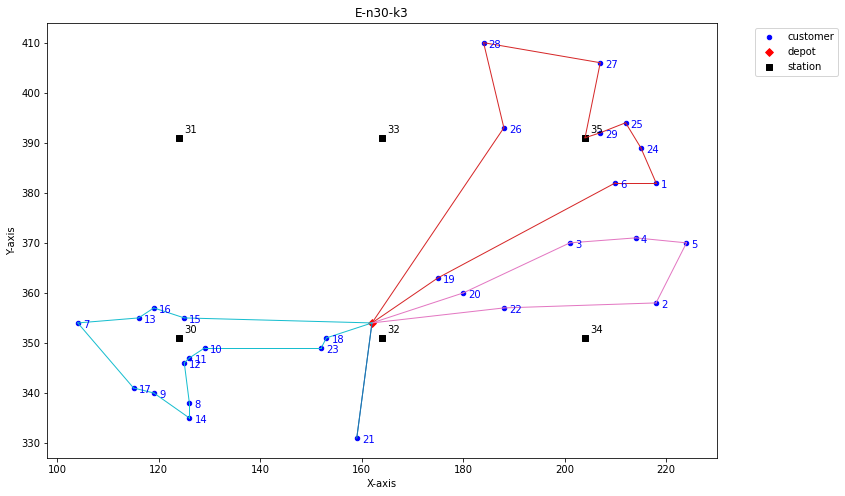

In [13]:
# instance_name = 'X-n214-k11.evrp'
instance_name = 'E-n30-k3.evrp'


file_dir = os.path.join(data_dir, instance_name)
instance = Benchmark_Instance(file_dir)
df = create_dataframe(instance)

# random.seed(2)
# individual = list(range(1, instance.dimension))
# random.shuffle(individual)
# routes = individual_2_route(individual, instance)

routes = [ [21], [26 , 28 , 27 , 35 , 29 , 25 , 24 , 1 , 6 , 19], [20 , 3 , 4 , 5 , 2 , 22], [15 , 16 , 13 , 7 , 17 , 9 , 14 , 8 , 12 , 11 , 10 , 23 , 18] ]

print(routes)
# print(df)

visualize_routes(routes, df, instance.name)

### Fitness Evaluation

* From the [WCCI-2020 benchmark report](https://mavrovouniotis.github.io/EVRPcompetition2020/TR-EVRP-Competition.pdf), the fitness evaluation is the total distance, namely, $$min\sum_{i \in V, j \in V, i \neq j} d_{ij}x_{ij}$$


In [14]:
def fitness_evaluation(individual, instance):
    '''Evaluate the generated routes
    
    Args:
        individual: a list of integers and each integer denote a customer
        instance: the benchmark instance got from the original data
        
    Returns:
        tuple - (float, ) single objective fitness, which is used to satisfy the requirement of `deap.creator` fitness
    '''
    routes = individual_2_route(individual, instance)
    
    
    total_distance = 0.0
    DISTANCE_MATRIX = instance.distance_matrix

    
    for route in routes:
        _route = [0] + route + [0]
        for current in range(1, len(_route)):
            prev_node = _route[current - 1]
            cur_node  = _route[current]
            total_distance += DISTANCE_MATRIX[prev_node][cur_node]
    
    return (total_distance, )

### Initialize Population

In [15]:

def generate_individual(num_of_customers):
    '''Generate individual randomly
    
    Args:
        num_of_customers: the number of customers
    
    Returns:
        individual - a list of integers (i.e., customers) 
    '''
    individual = list(range(1, num_of_customers))
    random.shuffle(individual)

    return individual

def init_population(seed, pop_size, ind_size):
    '''Initialize the population
    
    Args:
        seed: random seed, which makes the results reproductive
        pop_size: the population size
        ind_size: the individual size, but acctually the generated individual length is ind_size - 1
        
    Returns:
        a list of individual
    '''
    random.seed(seed)
    population = []
    for _ in range(pop_size):
        individual = generate_individual(ind_size)
        population.append(individual)
    return population


### Crossover & Selection

In [16]:
def cx_partialy_matched(ind1, ind2):
    '''Perform a partially matched crossover (PMX) on the given individuals.
    
    This function is a modified version of the `deap.tools.cxPartialyMatched` function
    that supports individual lists that start the `indexes` from 1 rather than 0.
    
    Args:
        ind1: A list of integers representing the first parent.
        ind2: A list of integers representing the second parent.
    
    Returns:
        A tuple of two variable pointers (`ind1` and `ind2`), which also means the two input arguments have been changed.
    '''
    # Convert individual lists to start with index 0
    ind_1 = [x - 1 for x in ind1]
    ind_2 = [x - 1 for x in ind2]
    
    # Perform crossover using the modified individual lists
    tmp_1, tmp_2 = tools.cxPartialyMatched(ind_1, ind_2)

    # Convert offspring lists back to start with index 1
    ans_1 = [x + 1 for x in tmp_1]
    ans_2 = [x + 1 for x in tmp_2]
    
    size =  min(len(ind1), len(ind2))
    for i in range(size):
        ind1[i] = ans_1[i]
        ind2[i] = ans_2[i]
    
    # Return the offspring
    return ind1, ind2


def selection(population, size, rate=0.2):
    '''This is a customized selection function. It will select a certain-size subset from the populaltion,
    and the subset has a proportion of elites.

    Args:
        population: A list of individuals, each of which is a list of values.
        size: the size of the selected subset from the population.
        rate: the proportion of elites.
    
    Returns:
        The selected subset of the population.
    '''
    top_size = int(size * rate)
    top_individuals = tools.selBest(population, top_size)  
    
    remaining_size = size - top_size
    remaining_individuals = tools.selRoulette(population, remaining_size) 
    
    selected_pop = top_individuals + remaining_individuals
    
    return selected_pop[:size]


def deduplicate_population(population):
    """Deduplicate a population by removing identical individuals.
    
    Args:
        population: A list of individuals, each of which is a list of values.
    
    Returns:
        A list of deduplicated individuals.
    """
    population.sort()
    length = len(population)
    lastItem = population[length - 1]
    for i in range(length - 2,-1,-1):
            currentItem = population[i]
            if currentItem == lastItem:
                    population.remove(currentItem)
            else:
                    lastItem = currentItem
    
    return population

### Utils

* try to make some files 
* plot the result line graph

In [17]:
def make_dirs_for_file(path):
    '''Make directories for the file
    
    Args:
        path: the given file path
    '''
    try:
        os.makedirs(os.path.dirname(path))
    except OSError:
        pass

def guess_path_type(path):
    '''judge the type of the given path
    
    Args:
        path: the given file path
    '''
    if os.path.isfile(path):
        return 'File'
    if os.path.isdir(path):
        return 'Directory'
    if os.path.islink(path):
        return 'Symbolic Link'
    if os.path.ismount(path):
        return 'Mount Point'
    return 'Path'

def exist(path, overwrite=False, display_info=False):
    '''judge whether it exists for the given path
    
    Args:
        path: the given file path
        overwrite: whether overwrite the file
        display_info: whether display the info of the path
    '''
    if os.path.exists(path):
        if overwrite:
            if display_info:
                print(f'{guess_path_type(path)}: {path} exists. Overwrite.')
            os.remove(path)
            return False
        if display_info:
            print(f'{guess_path_type(path)}: {path} exists.')
        return True
    if display_info:
        print(f'{guess_path_type(path)}: {path} does not exist.')
    return False

In [18]:
def plot_fitness_graph(df):
    """Plot a line graph for avg_fitness and min_fitness by generation using a DataFrame.
    
    Args:
        df: A pandas DataFrame containing 'generation', 'avg_fitness', and 'min_fitness' columns.
    """
    # Set the figure size (width, height) in inches
    plt.figure(figsize=(12, 6))

    # Plot the line graph for avg_fitness
    plt.plot(df['generation'], df['avg_fitness'], label='Average Fitness')

    # Plot the line graph for min_fitness
    plt.plot(df['generation'], df['min_fitness'], label='Minimum Fitness')

    # Set the labels for the X and Y axes
    plt.xlabel('Generation')
    plt.ylabel('Fitness')

    # Set the title for the graph
    plt.title('Fitness by Generation')

    # Add a legend to the graph
    plt.legend()

    # Display the graph
    plt.show()


### Complete Genetic Algorithm

In [43]:
def run_ga(instance_name, seed, pop_size, n_gen, rate_elite, cx_prob, mut_prob, immig_prop, export_csv=True):
    
    random.seed(seed)
    
    BASE_DIR = os.path.abspath(os.path.dirname(os.path.dirname('.')))
    DATA_DIR = os.path.join(BASE_DIR, 'evrp-benchmark-set')
    file_dir = os.path.join(data_dir, instance_name)
    
    instance = Benchmark_Instance(file_dir)
    df = create_dataframe(instance)
    
    IND_SIZE = instance.dimension - 1
    
    creator.create('FitnessMin', base.Fitness, weights=(-1.0, ))
    creator.create('Individual', list, fitness=creator.FitnessMin)
    toolbox = base.Toolbox()
    
    
    # -------- In `toolbox`, register regarding functions --------
    
    # individual and population initialization approach
    toolbox.register('indexes', random.sample, range(1, IND_SIZE + 1), IND_SIZE)
    toolbox.register('individual', tools.initIterate, creator.Individual, toolbox.indexes)
    toolbox.register('population', tools.initRepeat, list, toolbox.individual, n=pop_size)
    # evaluation
    toolbox.register('evaluate', fitness_evaluation, instance=instance)
    # selection
    toolbox.register('select', selection, rate=rate_elite)
    # mate (crossover)
    toolbox.register('mate', cx_partialy_matched)
    # mutation
    toolbox.register('mutate', tools.mutShuffleIndexes, indpb=mut_prob)
    
    
    csv_data = []
    print('----------------Start of evolution----------------')
    
    # Initialize population
    pop = toolbox.population()
    # Evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit
    print(f'  Evaluated {len(pop)} individuals')
    
    
    # Begin the evolution
    for gen in range(n_gen):
        print(f'---- Generation {gen} ----')
        
        
        # Clone the population, and the individuals produce offspring through crossover and mutation
        offspring = list(map(toolbox.clone, pop))
        # Apply crossover and mutation on the offspring
        # ---------------  Crossover  -----------------
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < cx_prob:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values
        # ---------------  Mutation  -----------------
        for mutant in offspring:
            if random.random() < mut_prob:
                toolbox.mutate(mutant)
                del mutant.fitness.values
        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        print(f'  Evaluated {len(invalid_ind)} individuals')

        # ---------------  Immigration  -----------------
        immigration = toolbox.population(n=int(pop_size * immig_prop))
        fitnesses = map(toolbox.evaluate, immigration)
        for ind, fit in zip(immigration, fitnesses):
            ind.fitness.values = fit
        
        # ---------------  Select  -----------------
        # Select the specific number of individuals from the current population pool
        selected_pop = toolbox.select(offspring + pop + immigration, pop_size)
        

        # The population is entirely replaced by the offspring
        pop[:] = selected_pop
        
        # Collect the statistical info of each generation
        # Gather all the fitnesses in one list and print the stats
        fits = [ind.fitness.values[0] for ind in pop]
        length = len(pop)
        mean = sum(fits) / length
        sum2 = sum([x**2 for x in fits])
        std = abs(sum2 / length - mean**2)**0.5
        print(f'  Min {min(fits)}') # the best result of each generation
        print(f'  Max {max(fits)}')
        print(f'  Avg {mean}')   # Reflect the direction of population evolution 
        print(f'  Std {std}')
        # Write data to holders for exporting results to CSV file
        if export_csv:
            csv_row = {
                'generation': gen,
                'evaluated_individuals': len(invalid_ind),
                'min_fitness': min(fits),
                'max_fitness': max(fits),
                'avg_fitness': mean,
                'std_fitness': std,
            }
            csv_data.append(csv_row)
    
    print('------------End of (successful) evolution------------', end='\n\n')
    
    
    best_ind = tools.selBest(pop, 1)[0]
    print(f'Best individual: {best_ind}')
    print(f'Fitness: {best_ind.fitness.values[0]}')
    routes = individual_2_route(best_ind, instance)
    for idx, route in enumerate(routes):
        _route = [0] + route + [0]
        print(f' vehicle {idx}: ', _route)
    print(f'Total cost: {best_ind.fitness.values[0]}')
    csv_file = ''
    if export_csv:
        csv_file_name = f'{instance_name}_seed{seed}_iS{IND_SIZE}_pS{pop_size}_rE{rate_elite}_cP{cx_prob}_mP{mut_prob}_iP{immig_prop}_nG{n_gen}.csv'
        csv_file = os.path.join(BASE_DIR, 'results', csv_file_name)
        print(f'Write to file: {csv_file}')
        make_dirs_for_file(path=csv_file)
        if not exist(path=csv_file, overwrite=True):
            with io.open(csv_file, 'wt', newline='') as file_object:
                fieldnames = [
                    'generation',
                    'evaluated_individuals',
                    'min_fitness',
                    'max_fitness',
                    'avg_fitness',
                    'std_fitness',
                ]
                writer = DictWriter(file_object, fieldnames=fieldnames, dialect='excel')
                writer.writeheader()
                for csv_row in csv_data:
                    writer.writerow(csv_row)
    
    return (best_ind, routes, best_ind.fitness.values[0], csv_file)        
        

In [23]:
fnmatch.filter(os.listdir(data_dir), '*.evrp')

['X-n685-k75.evrp',
 'E-n30-k3.evrp',
 'X-n1001-k43.evrp',
 'X-n214-k11.evrp',
 'E-n76-k7.evrp',
 'X-n459-k26.evrp',
 'E-n23-k3.evrp',
 'X-n916-k207.evrp',
 'X-n749-k98.evrp',
 'X-n351-k40.evrp',
 'X-n819-k171.evrp',
 'E-n101-k8.evrp',
 'E-n51-k5.evrp',
 'E-n33-k4.evrp',
 'X-n573-k30.evrp',
 'E-n22-k4.evrp',
 'X-n143-k7.evrp']

In [44]:

instance_name = 'E-n22-k4.evrp'


seed = 1
pop_size = 200
n_gen = 300
rate_elite = 0.2
cx_prob = 0.85
mut_prob = 0.1
immig_prop = 0.2

best_ind, routes, fitness, run_file = run_ga(instance_name, seed, pop_size, n_gen, rate_elite, 
                                   cx_prob, mut_prob, immig_prop, export_csv=True)


/data/home/exx866/.local/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/data/home/exx866/.local/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


----------------Start of evolution----------------
  Evaluated 200 individuals
---- Generation 0 ----
  Evaluated 168 individuals
  Min 681.7599714037453
  Max 1097.3518794864979
  Avg 892.8502478041368
  Std 88.54403840862618
---- Generation 1 ----
  Evaluated 180 individuals
  Min 681.7599714037453
  Max 1070.9642029025729
  Avg 877.5940809654513
  Std 97.81002073242539
---- Generation 2 ----
  Evaluated 173 individuals
  Min 681.7599714037453
  Max 1070.9642029025729
  Avg 874.344818414339
  Std 106.00937915032873
---- Generation 3 ----
  Evaluated 165 individuals
  Min 681.7599714037453
  Max 1077.994953176337
  Avg 855.9470313039769
  Std 112.18815291274794
---- Generation 4 ----
  Evaluated 165 individuals
  Min 681.7599714037453
  Max 1077.994953176337
  Avg 833.2607548710474
  Std 117.30365510577839
---- Generation 5 ----
  Evaluated 179 individuals
  Min 681.7599714037453
  Max 1075.1094959159539
  Avg 824.6840669822876
  Std 119.97178118987232
---- Generation 6 ----
  Evaluat

  Evaluated 180 individuals
  Min 571.3816878012523
  Max 1075.4476954534437
  Avg 815.2720910954945
  Std 179.9189461368249
---- Generation 58 ----
  Evaluated 177 individuals
  Min 571.3816878012523
  Max 1081.1093194589978
  Avg 811.7228356746401
  Std 169.0384276465016
---- Generation 59 ----
  Evaluated 173 individuals
  Min 571.3816878012523
  Max 1084.3416766042506
  Avg 794.9920412315427
  Std 186.93826240736496
---- Generation 60 ----
  Evaluated 179 individuals
  Min 571.3816878012523
  Max 1084.3416766042506
  Avg 800.0639940026416
  Std 181.63486026448518
---- Generation 61 ----
  Evaluated 181 individuals
  Min 565.0765191029473
  Max 1100.298357431617
  Avg 823.3511833335957
  Std 179.97715502161557
---- Generation 62 ----
  Evaluated 164 individuals
  Min 565.0765191029473
  Max 1099.6286635703545
  Avg 795.8976273990321
  Std 181.13126307720574
---- Generation 63 ----
  Evaluated 173 individuals
  Min 565.0765191029473
  Max 1102.5267001895138
  Avg 791.7595978224666
  

  Evaluated 170 individuals
  Min 557.9660756740597
  Max 1086.2359225201822
  Avg 794.9417057592063
  Std 181.55334213171565
---- Generation 113 ----
  Evaluated 179 individuals
  Min 557.9660756740597
  Max 1067.9281830741636
  Avg 805.2788127692766
  Std 181.71028919444018
---- Generation 114 ----
  Evaluated 174 individuals
  Min 557.9660756740597
  Max 1089.8297676042203
  Avg 800.1038858094574
  Std 188.5792736471138
---- Generation 115 ----
  Evaluated 178 individuals
  Min 557.9660756740597
  Max 1089.8297676042203
  Avg 779.3491137652137
  Std 184.95404083525193
---- Generation 116 ----
  Evaluated 175 individuals
  Min 557.9660756740597
  Max 1074.6373219109616
  Avg 766.558328197069
  Std 176.36960866442698
---- Generation 117 ----
  Evaluated 168 individuals
  Min 557.9660756740597
  Max 1074.6373219109616
  Avg 777.1861280951433
  Std 184.44748232238493
---- Generation 118 ----
  Evaluated 159 individuals
  Min 557.9660756740597
  Max 1087.1526728366823
  Avg 786.751755716

  Evaluated 173 individuals
  Min 541.4488987000029
  Max 1046.963729923842
  Avg 774.0421243195387
  Std 185.43501901946277
---- Generation 168 ----
  Evaluated 165 individuals
  Min 541.4488987000029
  Max 1062.493952669925
  Avg 774.8097097787719
  Std 187.87042849565094
---- Generation 169 ----
  Evaluated 174 individuals
  Min 541.4488987000029
  Max 1123.5206870377908
  Avg 789.3523115681742
  Std 188.0992405015204
---- Generation 170 ----
  Evaluated 180 individuals
  Min 541.4488987000029
  Max 1123.5206870377908
  Avg 799.556884465843
  Std 184.99172622234568
---- Generation 171 ----
  Evaluated 177 individuals
  Min 541.4488987000029
  Max 1128.7625429161653
  Avg 808.172719924246
  Std 182.94754121979653
---- Generation 172 ----
  Evaluated 179 individuals
  Min 541.4488987000029
  Max 1119.9065852986455
  Avg 801.6280845127518
  Std 191.98901657651646
---- Generation 173 ----
  Evaluated 183 individuals
  Min 541.4488987000029
  Max 1119.9065852986455
  Avg 793.574584755329

  Evaluated 166 individuals
  Min 541.4488987000029
  Max 1106.1518037769058
  Avg 790.2722064682242
  Std 186.58126909461072
---- Generation 223 ----
  Evaluated 180 individuals
  Min 541.4488987000029
  Max 1106.1518037769058
  Avg 818.5368211213321
  Std 186.97427043735323
---- Generation 224 ----
  Evaluated 168 individuals
  Min 541.4488987000029
  Max 1119.6874380588438
  Avg 804.8964924654017
  Std 200.62745931771354
---- Generation 225 ----
  Evaluated 175 individuals
  Min 541.4488987000029
  Max 1118.892552299615
  Avg 790.2581073076608
  Std 200.75324856096438
---- Generation 226 ----
  Evaluated 178 individuals
  Min 541.4488987000029
  Max 1106.1518037769058
  Avg 788.0688664751083
  Std 202.15987080854669
---- Generation 227 ----
  Evaluated 171 individuals
  Min 541.4488987000029
  Max 1106.1518037769058
  Avg 806.1247980229132
  Std 189.72763720675695
---- Generation 228 ----
  Evaluated 181 individuals
  Min 541.4488987000029
  Max 1106.1518037769058
  Avg 793.03501602

  Evaluated 173 individuals
  Min 541.4488987000029
  Max 1097.5678409545978
  Avg 810.8408065989415
  Std 184.13282751257694
---- Generation 278 ----
  Evaluated 169 individuals
  Min 541.4488987000029
  Max 1095.0179734712171
  Avg 811.070111529178
  Std 185.90522632898197
---- Generation 279 ----
  Evaluated 175 individuals
  Min 541.4488987000029
  Max 1115.544245196796
  Avg 822.3343809048896
  Std 188.254392026654
---- Generation 280 ----
  Evaluated 178 individuals
  Min 541.4488987000029
  Max 1115.544245196796
  Avg 803.9426623291312
  Std 187.33182263247932
---- Generation 281 ----
  Evaluated 159 individuals
  Min 541.4488987000029
  Max 1115.544245196796
  Avg 779.4580415464821
  Std 183.2780966511252
---- Generation 282 ----
  Evaluated 182 individuals
  Min 541.4488987000029
  Max 1115.544245196796
  Avg 781.043288424042
  Std 194.27522488869712
---- Generation 283 ----
  Evaluated 178 individuals
  Min 541.4488987000029
  Max 1115.544245196796
  Avg 789.8381536622248
  S

In [45]:
# inds = [[19, 20, 22, 14, 11, 13, 9, 8, 4, 21, 10, 1, 5, 12, 2, 15, 16, 17, 3, 6, 7, 18], [19, 20, 22, 14, 11, 13, 9, 8, 4, 21, 10, 1, 5, 12, 2, 15, 16, 17, 3, 6, 7, 18], [15, 20, 22, 14, 11, 13, 9, 12, 4, 21, 10, 1, 5, 8, 2, 19, 16, 17, 3, 6, 7, 18], [19, 20, 22, 14, 11, 13, 9, 8, 4, 21, 10, 1, 5, 12, 2, 15, 16, 17, 3, 6, 7, 18], [19, 20, 22, 14, 11, 13, 9, 8, 4, 21, 10, 1, 5, 12, 2, 15, 16, 17, 3, 6, 7, 18], [19, 20, 22, 14, 11, 13, 9, 8, 4, 21, 10, 1, 5, 12, 2, 15, 16, 3, 17, 6, 7, 18], [19, 20, 22, 14, 11, 13, 9, 8, 4, 21, 10, 1, 5, 12, 2, 15, 16, 17, 3, 6, 7, 18], [19, 20, 22, 14, 11, 13, 9, 8, 4, 21, 10, 1, 7, 12, 2, 15, 16, 17, 3, 6, 5, 18], [19, 20, 22, 14, 13, 11, 9, 8, 4, 21, 10, 1, 5, 12, 2, 15, 16, 17, 3, 6, 7, 18], [19, 20, 22, 14, 11, 13, 9, 8, 4, 21, 10, 1, 5, 12, 2, 15, 16, 3, 17, 6, 7, 18], [19, 20, 22, 14, 6, 13, 9, 8, 4, 21, 10, 1, 5, 12, 2, 15, 16, 3, 17, 11, 7, 18], [19, 20, 22, 14, 11, 13, 9, 8, 4, 21, 10, 1, 5, 12, 2, 15, 16, 17, 3, 6, 7, 18], [19, 20, 22, 14, 11, 13, 9, 8, 4, 21, 10, 1, 5, 12, 2, 15, 16, 17, 3, 6, 7, 18], [19, 20, 22, 14, 11, 13, 9, 8, 4, 21, 10, 1, 5, 12, 2, 15, 16, 17, 3, 6, 7, 18], [5, 7, 22, 14, 16, 11, 9, 19, 4, 21, 10, 1, 8, 12, 17, 15, 13, 2, 3, 6, 20, 18], [19, 20, 22, 14, 11, 13, 9, 8, 4, 21, 10, 1, 5, 12, 2, 15, 16, 17, 3, 6, 7, 18], [19, 20, 22, 14, 2, 13, 9, 8, 4, 21, 10, 1, 5, 12, 11, 15, 16, 17, 3, 6, 7, 18], [19, 20, 22, 14, 11, 13, 9, 8, 4, 21, 10, 1, 5, 12, 2, 15, 16, 3, 17, 6, 7, 18], [19, 2, 22, 14, 11, 13, 9, 18, 15, 21, 10, 1, 4, 12, 20, 16, 5, 3, 17, 6, 7, 8], [19, 20, 22, 14, 11, 13, 9, 8, 4, 21, 10, 1, 5, 12, 2, 15, 16, 17, 3, 6, 7, 18], [19, 20, 22, 14, 13, 11, 9, 8, 4, 21, 10, 1, 5, 12, 2, 15, 16, 3, 17, 6, 7, 18], [19, 20, 22, 14, 11, 13, 9, 8, 4, 21, 10, 1, 5, 12, 2, 15, 16, 17, 3, 6, 7, 18], [19, 20, 22, 14, 13, 11, 9, 8, 4, 21, 10, 1, 5, 12, 2, 15, 16, 3, 17, 6, 7, 18], [19, 20, 22, 14, 11, 13, 9, 8, 4, 21, 10, 1, 7, 12, 2, 15, 16, 17, 3, 6, 5, 18], [19, 20, 22, 14, 11, 13, 9, 8, 4, 21, 10, 1, 5, 12, 2, 15, 16, 17, 3, 6, 7, 18], [19, 20, 22, 14, 6, 13, 9, 8, 4, 21, 10, 1, 5, 12, 2, 15, 16, 17, 3, 11, 7, 18], [19, 20, 22, 14, 11, 13, 21, 8, 4, 9, 10, 1, 7, 12, 2, 15, 16, 17, 3, 6, 5, 18], [19, 20, 22, 14, 11, 13, 9, 8, 4, 21, 10, 1, 5, 12, 6, 15, 16, 17, 3, 2, 7, 18], [19, 20, 22, 14, 6, 13, 9, 8, 4, 21, 10, 1, 5, 12, 2, 15, 16, 17, 3, 11, 7, 18], [14, 20, 22, 19, 2, 13, 9, 8, 4, 21, 10, 1, 5, 12, 11, 15, 16, 17, 3, 6, 7, 18], [19, 20, 22, 14, 11, 13, 9, 8, 4, 21, 10, 1, 5, 12, 2, 15, 16, 3, 17, 6, 7, 18], [19, 20, 22, 14, 11, 13, 9, 8, 4, 21, 10, 1, 7, 12, 2, 15, 16, 17, 3, 6, 5, 18], [19, 20, 22, 14, 11, 13, 9, 8, 4, 21, 10, 1, 5, 12, 2, 15, 16, 17, 3, 6, 7, 18], [19, 20, 22, 14, 11, 13, 9, 8, 4, 21, 10, 1, 5, 12, 2, 15, 16, 17, 3, 6, 7, 18], [19, 20, 22, 14, 13, 11, 9, 8, 4, 21, 10, 1, 5, 12, 2, 15, 16, 3, 17, 6, 7, 18], [19, 20, 22, 14, 11, 13, 9, 8, 4, 21, 10, 1, 5, 12, 2, 15, 16, 17, 3, 6, 7, 18], [19, 20, 22, 14, 11, 13, 9, 8, 4, 21, 10, 1, 5, 12, 2, 15, 16, 17, 3, 6, 7, 18], [15, 20, 10, 13, 9, 7, 4, 5, 18, 2, 22, 16, 17, 8, 12, 21, 19, 6, 1, 3, 14, 11], [18, 14, 17, 22, 20, 13, 11, 3, 4, 16, 10, 19, 6, 1, 2, 15, 21, 5, 12, 8, 7, 9], [15, 20, 22, 14, 11, 13, 9, 17, 4, 21, 10, 1, 5, 6, 3, 2, 19, 18, 16, 12, 7, 8], [4, 15, 13, 9, 20, 17, 3, 18, 22, 12, 19, 11, 21, 14, 6, 16, 10, 8, 2, 7, 5, 1], [19, 8, 13, 9, 4, 10, 12, 6, 18, 14, 20, 22, 7, 1, 5, 2, 11, 3, 15, 17, 16, 21], [20, 13, 14, 12, 3, 22, 17, 5, 9, 11, 7, 10, 15, 4, 2, 18, 6, 16, 1, 8, 21, 19], [19, 10, 22, 1, 11, 13, 9, 7, 4, 21, 8, 14, 5, 18, 15, 20, 12, 17, 3, 6, 2, 16], [19, 20, 22, 14, 11, 13, 9, 8, 16, 5, 10, 1, 21, 12, 2, 15, 4, 17, 3, 6, 7, 18], [19, 5, 22, 11, 13, 16, 9, 8, 4, 21, 10, 1, 7, 17, 2, 15, 6, 3, 12, 14, 20, 18], [15, 18, 8, 19, 16, 4, 1, 22, 2, 10, 20, 3, 13, 11, 7, 9, 14, 5, 17, 6, 21, 12], [22, 20, 10, 19, 13, 1, 7, 14, 9, 21, 11, 12, 8, 4, 2, 15, 16, 17, 3, 6, 5, 18], [19, 20, 18, 14, 6, 13, 9, 8, 4, 17, 10, 1, 5, 12, 2, 15, 16, 21, 3, 11, 7, 22], [6, 16, 3, 11, 14, 8, 18, 2, 9, 12, 1, 15, 13, 17, 4, 20, 21, 10, 19, 7, 22, 5], [1, 18, 6, 5, 19, 16, 3, 13, 9, 17, 15, 7, 12, 4, 8, 20, 2, 10, 14, 22, 11, 21], [10, 3, 13, 17, 19, 2, 14, 22, 20, 7, 8, 9, 21, 12, 4, 16, 6, 15, 1, 5, 18, 11], [8, 20, 11, 1, 13, 16, 10, 22, 6, 12, 19, 17, 5, 18, 15, 4, 14, 3, 2, 21, 7, 9], [19, 11, 14, 13, 20, 10, 4, 6, 18, 1, 5, 16, 17, 12, 2, 15, 21, 7, 3, 8, 22, 9], [18, 17, 22, 5, 11, 13, 9, 8, 4, 16, 14, 21, 7, 3, 1, 19, 15, 6, 2, 12, 10, 20], [5, 20, 16, 6, 2, 19, 17, 7, 11, 14, 8, 1, 21, 22, 3, 18, 12, 15, 13, 10, 4, 9], [7, 21, 8, 19, 6, 15, 13, 10, 9, 20, 1, 5, 22, 18, 3, 17, 11, 12, 4, 2, 16, 14], [4, 20, 22, 7, 17, 13, 2, 11, 19, 21, 14, 1, 5, 6, 3, 10, 16, 18, 9, 12, 15, 8], [9, 19, 6, 10, 8, 1, 4, 17, 2, 3, 7, 12, 18, 13, 20, 15, 16, 11, 21, 22, 14, 5], [16, 20, 22, 14, 11, 13, 9, 8, 2, 10, 17, 18, 12, 4, 1, 15, 19, 21, 3, 5, 7, 6], [20, 15, 4, 14, 11, 13, 8, 9, 6, 21, 10, 1, 5, 17, 7, 3, 12, 19, 18, 22, 16, 2], [19, 15, 22, 6, 13, 7, 9, 14, 4, 2, 20, 5, 1, 8, 18, 12, 16, 11, 3, 17, 10, 21], [18, 7, 19, 11, 12, 1, 9, 8, 2, 20, 21, 5, 13, 16, 22, 15, 14, 17, 6, 10, 3, 4], [3, 5, 21, 22, 18, 15, 17, 8, 19, 1, 16, 7, 4, 11, 14, 9, 13, 20, 2, 6, 10, 12], [10, 16, 19, 6, 2, 12, 4, 13, 20, 3, 7, 17, 15, 11, 8, 9, 14, 1, 21, 22, 5, 18], [10, 5, 22, 1, 11, 13, 9, 8, 4, 21, 19, 14, 20, 12, 2, 15, 16, 17, 3, 6, 7, 18], [12, 19, 21, 18, 6, 8, 11, 3, 15, 16, 10, 1, 5, 9, 14, 13, 2, 22, 7, 4, 20, 17], [19, 9, 14, 22, 20, 10, 6, 8, 4, 21, 13, 1, 5, 12, 11, 15, 16, 17, 3, 2, 7, 18], [19, 4, 16, 8, 11, 1, 10, 5, 12, 21, 6, 9, 14, 20, 2, 15, 22, 17, 3, 13, 7, 18], [18, 16, 12, 6, 9, 2, 13, 14, 17, 21, 5, 1, 10, 22, 11, 15, 20, 3, 19, 4, 8, 7], [21, 20, 4, 8, 13, 11, 2, 6, 12, 19, 7, 1, 5, 17, 9, 15, 16, 22, 3, 14, 10, 18], [9, 21, 6, 10, 11, 13, 4, 12, 20, 3, 7, 5, 18, 22, 2, 15, 16, 17, 19, 1, 14, 8], [19, 20, 22, 14, 8, 12, 9, 11, 4, 21, 10, 1, 5, 13, 2, 15, 16, 17, 3, 6, 7, 18], [3, 6, 18, 10, 8, 1, 12, 7, 11, 2, 13, 4, 5, 16, 20, 22, 15, 17, 14, 9, 21, 19], [20, 8, 9, 4, 10, 7, 11, 2, 16, 13, 6, 18, 22, 19, 5, 21, 3, 17, 12, 1, 15, 14], [3, 1, 6, 21, 15, 11, 10, 17, 18, 20, 13, 9, 2, 22, 19, 14, 4, 12, 16, 8, 5, 7], [18, 20, 4, 2, 7, 14, 11, 22, 13, 8, 15, 9, 3, 17, 19, 10, 12, 6, 21, 16, 5, 1], [4, 17, 16, 8, 21, 9, 18, 14, 5, 10, 22, 2, 12, 19, 6, 11, 20, 1, 13, 3, 7, 15], [9, 18, 13, 20, 5, 11, 4, 21, 17, 10, 22, 1, 6, 12, 16, 15, 8, 3, 2, 7, 14, 19], [18, 16, 4, 14, 2, 9, 11, 6, 12, 19, 7, 1, 5, 17, 22, 15, 20, 21, 3, 13, 8, 10], [10, 2, 6, 20, 1, 17, 5, 9, 7, 15, 4, 19, 11, 18, 12, 8, 3, 16, 21, 22, 14, 13], [15, 8, 12, 7, 18, 22, 16, 19, 11, 21, 10, 20, 4, 17, 14, 2, 5, 1, 13, 3, 9, 6], [19, 20, 22, 10, 2, 21, 9, 8, 4, 13, 5, 3, 14, 12, 11, 15, 16, 17, 1, 6, 7, 18], [1, 8, 2, 16, 12, 11, 15, 18, 7, 22, 14, 3, 21, 13, 4, 6, 17, 20, 9, 5, 19, 10], [4, 19, 8, 1, 14, 21, 7, 9, 2, 17, 12, 11, 6, 5, 13, 22, 16, 10, 15, 3, 18, 20], [19, 20, 22, 14, 11, 1, 2, 6, 15, 5, 17, 8, 7, 18, 10, 12, 13, 3, 21, 9, 16, 4], [9, 10, 1, 8, 21, 13, 19, 14, 4, 11, 20, 22, 5, 12, 2, 15, 16, 3, 17, 6, 7, 18], [18, 4, 21, 13, 7, 8, 5, 12, 22, 17, 2, 19, 10, 9, 3, 20, 14, 16, 15, 6, 11, 1], [9, 21, 12, 1, 13, 18, 6, 10, 16, 22, 19, 20, 17, 4, 5, 14, 15, 2, 3, 7, 11, 8], [8, 20, 22, 10, 2, 9, 18, 5, 1, 6, 16, 7, 19, 12, 11, 15, 14, 3, 17, 21, 4, 13], [16, 5, 6, 14, 11, 18, 13, 19, 4, 21, 10, 1, 8, 20, 12, 22, 15, 2, 17, 7, 3, 9], [2, 10, 20, 17, 21, 22, 14, 9, 1, 5, 15, 18, 19, 3, 12, 4, 13, 11, 6, 16, 7, 8], [6, 12, 2, 1, 22, 17, 9, 3, 20, 5, 4, 11, 7, 18, 15, 8, 13, 14, 10, 19, 21, 16], [13, 20, 22, 8, 12, 19, 6, 4, 14, 21, 10, 1, 7, 11, 2, 15, 16, 17, 3, 9, 5, 18], [19, 12, 15, 17, 11, 13, 9, 14, 8, 22, 4, 18, 21, 2, 6, 10, 1, 16, 20, 7, 3, 5], [2, 20, 22, 14, 19, 13, 5, 10, 4, 21, 12, 9, 15, 8, 6, 1, 16, 3, 18, 11, 7, 17], [10, 5, 20, 14, 4, 21, 15, 11, 8, 7, 19, 22, 1, 12, 2, 9, 16, 17, 3, 6, 13, 18], [2, 8, 7, 17, 21, 18, 6, 4, 1, 16, 12, 3, 14, 13, 9, 15, 22, 20, 11, 5, 19, 10], [13, 18, 6, 16, 14, 11, 15, 9, 2, 22, 8, 19, 12, 5, 3, 20, 21, 17, 10, 7, 4, 1], [2, 16, 22, 17, 5, 14, 9, 8, 4, 21, 10, 11, 7, 12, 13, 3, 15, 18, 1, 20, 19, 6], [19, 20, 22, 9, 1, 17, 10, 8, 11, 18, 13, 5, 7, 12, 2, 15, 16, 14, 3, 6, 4, 21], [11, 3, 7, 17, 1, 15, 6, 18, 4, 21, 10, 16, 5, 22, 2, 13, 19, 14, 12, 9, 8, 20], [7, 9, 20, 8, 15, 14, 11, 4, 10, 1, 13, 19, 5, 2, 3, 12, 21, 17, 22, 6, 18, 16], [12, 10, 8, 9, 19, 6, 22, 16, 7, 18, 20, 1, 3, 21, 2, 13, 14, 17, 11, 15, 4, 5], [17, 22, 14, 20, 5, 1, 8, 10, 2, 12, 16, 4, 21, 18, 13, 6, 9, 11, 19, 7, 15, 3], [8, 10, 9, 4, 11, 13, 6, 2, 16, 5, 22, 14, 7, 18, 15, 20, 12, 17, 3, 19, 21, 1], [19, 13, 6, 3, 4, 20, 9, 11, 17, 7, 22, 1, 5, 12, 2, 15, 16, 21, 14, 8, 10, 18], [19, 20, 22, 14, 11, 13, 9, 8, 4, 21, 12, 1, 5, 10, 2, 15, 3, 17, 16, 6, 7, 18], [16, 13, 6, 21, 12, 19, 8, 4, 9, 11, 15, 1, 18, 22, 3, 17, 14, 5, 10, 2, 7, 20], [13, 11, 15, 17, 4, 16, 6, 12, 14, 22, 8, 18, 21, 2, 9, 10, 1, 19, 20, 7, 3, 5], [19, 20, 22, 14, 11, 13, 9, 8, 4, 21, 10, 1, 5, 12, 2, 15, 16, 3, 17, 6, 7, 18], [7, 19, 8, 1, 12, 22, 2, 18, 4, 21, 14, 11, 6, 5, 13, 17, 16, 10, 15, 3, 9, 20], [19, 20, 21, 14, 11, 13, 9, 8, 7, 22, 10, 1, 5, 12, 2, 15, 16, 17, 3, 6, 4, 18], [19, 10, 21, 18, 9, 8, 5, 3, 7, 22, 14, 11, 12, 6, 13, 15, 16, 17, 2, 1, 4, 20], [7, 19, 8, 11, 6, 21, 13, 18, 4, 22, 20, 1, 5, 12, 2, 17, 16, 10, 15, 3, 9, 14], [19, 1, 13, 15, 18, 5, 22, 20, 12, 6, 7, 17, 11, 21, 3, 8, 10, 2, 9, 14, 4, 16], [19, 7, 16, 12, 17, 13, 9, 3, 10, 1, 4, 22, 6, 20, 14, 11, 15, 8, 5, 2, 21, 18], [18, 19, 6, 2, 4, 22, 13, 17, 14, 21, 10, 1, 5, 12, 16, 15, 11, 3, 20, 7, 9, 8], [19, 20, 22, 14, 11, 3, 9, 8, 4, 21, 10, 1, 5, 12, 2, 15, 17, 16, 13, 6, 7, 18], [9, 16, 18, 11, 4, 2, 19, 8, 22, 12, 20, 10, 13, 7, 6, 21, 14, 17, 3, 1, 5, 15], [20, 22, 8, 16, 10, 1, 15, 9, 12, 17, 11, 14, 3, 19, 21, 6, 2, 13, 18, 5, 7, 4], [11, 8, 9, 14, 21, 17, 15, 18, 22, 2, 1, 10, 4, 20, 3, 13, 12, 19, 5, 7, 6, 16], [19, 20, 22, 8, 11, 13, 9, 3, 4, 21, 10, 1, 5, 12, 2, 15, 16, 17, 14, 6, 7, 18], [16, 10, 3, 18, 11, 14, 6, 21, 5, 12, 9, 7, 2, 19, 1, 13, 20, 22, 8, 4, 15, 17], [9, 6, 20, 17, 18, 14, 11, 22, 8, 1, 4, 21, 5, 16, 12, 10, 15, 3, 13, 2, 19, 7], [22, 4, 6, 7, 1, 17, 9, 8, 20, 21, 5, 19, 10, 18, 2, 15, 3, 16, 14, 11, 12, 13], [9, 15, 16, 17, 21, 20, 2, 11, 1, 5, 8, 14, 7, 18, 19, 12, 13, 3, 10, 6, 22, 4], [13, 20, 14, 22, 11, 9, 12, 3, 7, 18, 10, 15, 4, 1, 2, 6, 8, 21, 17, 19, 16, 5], [19, 10, 22, 14, 12, 15, 9, 8, 21, 2, 20, 5, 7, 11, 18, 1, 16, 17, 3, 6, 13, 4], [19, 1, 22, 12, 11, 5, 14, 8, 18, 21, 10, 7, 13, 9, 4, 15, 16, 6, 3, 17, 20, 2], [19, 9, 14, 16, 13, 8, 5, 11, 20, 21, 7, 1, 15, 2, 12, 4, 22, 17, 3, 6, 10, 18], [15, 22, 19, 14, 12, 2, 20, 8, 9, 3, 10, 17, 4, 13, 11, 5, 16, 1, 21, 6, 7, 18], [19, 22, 5, 2, 10, 20, 3, 6, 11, 14, 15, 1, 18, 8, 9, 17, 13, 21, 4, 12, 7, 16], [19, 13, 2, 6, 4, 20, 9, 1, 17, 8, 11, 7, 5, 22, 10, 12, 15, 3, 16, 14, 21, 18], [4, 19, 10, 18, 12, 2, 6, 9, 1, 5, 14, 11, 21, 22, 13, 17, 7, 8, 15, 3, 16, 20], [9, 6, 20, 17, 21, 5, 2, 11, 16, 22, 8, 14, 7, 18, 15, 12, 13, 3, 10, 19, 1, 4], [9, 10, 21, 15, 1, 17, 12, 5, 16, 22, 19, 20, 8, 4, 6, 14, 7, 2, 3, 13, 11, 18], [9, 10, 21, 15, 1, 17, 12, 5, 16, 22, 19, 20, 8, 4, 6, 14, 7, 2, 3, 13, 11, 18], [12, 20, 22, 7, 4, 18, 9, 5, 15, 16, 19, 3, 21, 6, 2, 10, 1, 11, 14, 8, 13, 17], [1, 3, 18, 22, 19, 9, 16, 17, 8, 11, 15, 20, 13, 12, 6, 10, 2, 21, 7, 4, 5, 14], [12, 13, 16, 6, 11, 1, 3, 18, 17, 21, 19, 7, 20, 2, 22, 8, 9, 15, 4, 10, 5, 14], [5, 20, 8, 6, 19, 12, 9, 22, 18, 14, 17, 4, 10, 3, 2, 16, 13, 21, 1, 15, 7, 11], [1, 20, 21, 4, 7, 6, 11, 2, 14, 8, 22, 17, 16, 10, 9, 18, 12, 3, 13, 5, 19, 15], [17, 13, 22, 9, 4, 20, 16, 11, 19, 7, 6, 1, 21, 10, 2, 15, 3, 5, 14, 8, 12, 18], [19, 13, 22, 11, 12, 1, 9, 8, 2, 4, 20, 5, 7, 14, 6, 15, 16, 17, 3, 18, 10, 21], [11, 20, 22, 14, 10, 15, 9, 8, 4, 21, 18, 1, 5, 12, 17, 13, 16, 19, 3, 2, 7, 6], [5, 16, 19, 7, 2, 12, 18, 6, 9, 1, 22, 17, 15, 11, 8, 20, 14, 3, 21, 13, 10, 4], [18, 22, 5, 10, 9, 14, 4, 13, 20, 3, 7, 16, 17, 1, 21, 19, 15, 8, 2, 12, 6, 11], [9, 16, 6, 10, 4, 12, 8, 21, 19, 11, 15, 1, 18, 22, 3, 17, 14, 5, 13, 2, 7, 20], [19, 10, 6, 13, 8, 21, 4, 16, 20, 3, 7, 5, 18, 22, 2, 15, 12, 17, 9, 1, 14, 11], [5, 17, 8, 1, 7, 19, 14, 20, 9, 4, 3, 2, 18, 11, 6, 15, 22, 10, 16, 13, 21, 12], [1, 21, 16, 12, 14, 18, 3, 5, 7, 17, 13, 4, 9, 20, 2, 6, 15, 19, 8, 10, 22, 11], [19, 10, 21, 8, 11, 16, 6, 15, 1, 17, 3, 9, 2, 22, 18, 13, 4, 7, 5, 14, 12, 20], [21, 20, 22, 14, 11, 13, 9, 8, 4, 19, 10, 1, 5, 12, 2, 15, 16, 3, 17, 6, 7, 18], [14, 15, 2, 13, 20, 10, 12, 6, 9, 1, 22, 16, 17, 18, 5, 19, 21, 11, 4, 8, 7, 3], [9, 7, 17, 22, 15, 13, 3, 8, 4, 1, 16, 14, 19, 12, 2, 21, 20, 6, 5, 18, 10, 11], [19, 18, 3, 8, 12, 14, 17, 21, 11, 2, 15, 9, 5, 13, 4, 10, 1, 22, 16, 6, 7, 20], [19, 5, 16, 14, 6, 12, 1, 8, 13, 21, 10, 17, 4, 2, 20, 18, 3, 9, 22, 11, 7, 15], [19, 20, 22, 14, 11, 13, 9, 8, 4, 21, 10, 1, 5, 12, 6, 15, 16, 17, 3, 2, 7, 18], [19, 20, 22, 14, 2, 13, 9, 8, 4, 21, 10, 1, 5, 12, 11, 15, 16, 17, 3, 6, 7, 18], [19, 12, 22, 14, 2, 13, 9, 8, 4, 21, 10, 1, 5, 20, 11, 15, 16, 17, 3, 6, 7, 18], [13, 20, 22, 14, 11, 12, 9, 8, 4, 21, 10, 1, 5, 6, 3, 16, 19, 17, 18, 7, 2, 15], [19, 5, 22, 14, 11, 12, 8, 21, 10, 15, 3, 18, 2, 13, 20, 9, 16, 17, 4, 6, 7, 1], [6, 10, 17, 15, 22, 11, 9, 8, 3, 21, 4, 1, 20, 12, 5, 18, 16, 14, 2, 19, 7, 13], [11, 16, 4, 8, 2, 9, 18, 6, 12, 19, 7, 1, 5, 10, 13, 15, 20, 3, 14, 22, 21, 17], [2, 10, 11, 1, 13, 8, 18, 22, 16, 5, 7, 19, 20, 17, 15, 12, 4, 3, 9, 14, 21, 6], [1, 8, 16, 5, 15, 19, 6, 3, 4, 7, 10, 13, 11, 21, 17, 14, 12, 20, 9, 22, 2, 18], [4, 22, 13, 5, 10, 6, 7, 8, 14, 21, 18, 1, 11, 20, 2, 15, 9, 12, 19, 3, 16, 17], [14, 19, 17, 7, 11, 13, 3, 4, 10, 8, 9, 18, 5, 2, 21, 20, 6, 1, 22, 12, 15, 16]]
# instance_name = 'E-n23-k3.evrp'
# instance = Benchmark_Instance(os.path.join(data_dir, instance_name))

# # for idx, ind in enumerate(inds):
# #     cost = fitness_evaluation(ind, instance)
# #     print(idx, ind, cost)
    
# ind = inds[55]
# fitness_evaluation(ind, instance)


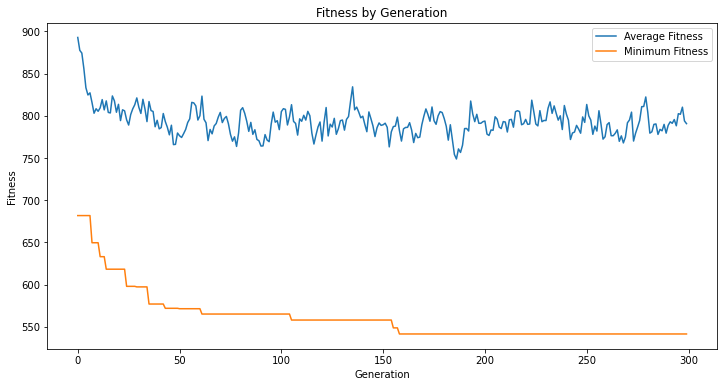

Excepted optimum: 384.678035
The optimum of my code: 541.4488987000029
vehicle 0:  [12, 7, 2, 29, 6, 16]
vehicle 1:  [13, 19, 20, 26]
vehicle 2:  [4, 3, 1, 29, 5, 10]
vehicle 3:  [11, 8, 9, 28, 14, 21, 17, 26, 18, 15]


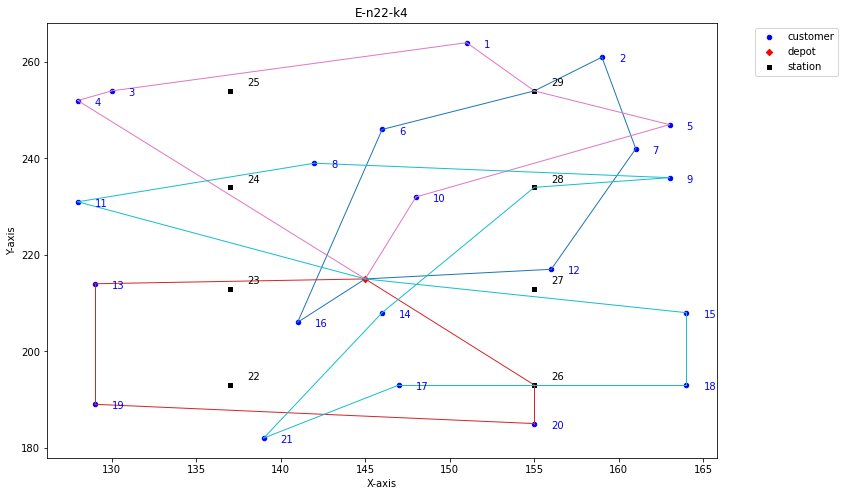

In [46]:
instance = Benchmark_Instance(os.path.join(data_dir, instance_name))
df = create_dataframe(instance)

df_run = pd.read_csv(run_file)
plot_fitness_graph(df_run)

print(f'Excepted optimum: {instance.optimum}')
print(f'The optimum of my code: {fitness}')

for idx, route in enumerate(routes):
    print(f'vehicle {idx}: ', route)
visualize_routes(routes, df, instance.name)





************************** E-n30-k3.evrp ****************************
----------------Start of evolution----------------
  Evaluated 200 individuals
---- Generation 0 ----
  Evaluated 164 individuals
  Min 1390.9851890674738
  Max 2248.5813210073256
  Avg 1817.5557639203369
  Std 207.43513371961828
---- Generation 1 ----


/data/home/exx866/.local/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/data/home/exx866/.local/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


  Evaluated 169 individuals
  Min 1390.9851890674738
  Max 2374.0743062369925
  Avg 1767.0956448196189
  Std 227.29691703228855
---- Generation 2 ----
  Evaluated 174 individuals
  Min 1218.0836787935707
  Max 2233.134699204284
  Avg 1742.769769092296
  Std 224.96564240788268
---- Generation 3 ----
  Evaluated 182 individuals
  Min 1194.8462072771335
  Max 2233.134699204284
  Avg 1716.412017450336
  Std 251.22091245374494
---- Generation 4 ----
  Evaluated 175 individuals
  Min 1194.8462072771335
  Max 2253.8143587337186
  Avg 1688.5349914984063
  Std 261.28106633556536
---- Generation 5 ----
  Evaluated 172 individuals
  Min 1194.8462072771335
  Max 2253.8143587337186
  Avg 1661.4935235012526
  Std 278.8052010712598
---- Generation 6 ----
  Evaluated 172 individuals
  Min 1089.800492813229
  Max 2296.468660763166
  Avg 1635.579009603746
  Std 293.9485004598904
---- Generation 7 ----
  Evaluated 169 individuals
  Min 1089.800492813229
  Max 2178.605406780991
  Avg 1621.2425739174628
  

  Evaluated 168 individuals
  Min 865.5068458725697
  Max 2277.9171888125948
  Avg 1600.050076540162
  Std 487.71627733864085
---- Generation 58 ----
  Evaluated 179 individuals
  Min 798.2151430586285
  Max 2277.9171888125948
  Avg 1581.2407843533301
  Std 506.36791967696706
---- Generation 59 ----
  Evaluated 168 individuals
  Min 798.2151430586285
  Max 2277.9171888125948
  Avg 1616.4084463478068
  Std 488.1932027555721
---- Generation 60 ----
  Evaluated 182 individuals
  Min 798.2151430586285
  Max 2277.9171888125948
  Avg 1571.1635417733448
  Std 492.9186669237043
---- Generation 61 ----
  Evaluated 165 individuals
  Min 798.2151430586285
  Max 2230.044025771552
  Avg 1558.2249367661848
  Std 493.35488264686944
---- Generation 62 ----
  Evaluated 169 individuals
  Min 798.2151430586285
  Max 2230.044025771552
  Avg 1604.7421813315977
  Std 483.8004442726511
---- Generation 63 ----
  Evaluated 187 individuals
  Min 798.2151430586285
  Max 2254.3331638769346
  Avg 1549.523353658022

  Evaluated 173 individuals
  Min 762.8339466134329
  Max 2290.8337688794163
  Avg 1522.8485966799083
  Std 549.1722816093014
---- Generation 113 ----
  Evaluated 181 individuals
  Min 762.8339466134329
  Max 2293.673422092014
  Avg 1496.898545668819
  Std 541.680731247378
---- Generation 114 ----
  Evaluated 175 individuals
  Min 762.8339466134329
  Max 2290.8337688794163
  Avg 1458.4312228893361
  Std 536.0726402417473
---- Generation 115 ----
  Evaluated 184 individuals
  Min 762.8339466134329
  Max 2290.8337688794163
  Avg 1484.6212969346159
  Std 513.6969208174316
---- Generation 116 ----
  Evaluated 165 individuals
  Min 762.8339466134329
  Max 2206.9797759528064
  Avg 1540.1747056131353
  Std 519.761657395112
---- Generation 117 ----
  Evaluated 179 individuals
  Min 762.8339466134329
  Max 2318.469172111859
  Avg 1592.474043223792
  Std 522.2193923934635
---- Generation 118 ----
  Evaluated 177 individuals
  Min 762.8339466134329
  Max 2325.776949610935
  Avg 1551.5500780371067

  Evaluated 181 individuals
  Min 747.7306319774347
  Max 2232.8665608053807
  Avg 1514.296752259931
  Std 538.1573666038463
---- Generation 170 ----
  Evaluated 172 individuals
  Min 747.7306319774347
  Max 2232.8665608053807
  Avg 1548.59561382116
  Std 527.2210383128491
---- Generation 171 ----
  Evaluated 184 individuals
  Min 747.7306319774347
  Max 2320.198427095255
  Avg 1569.1286606821388
  Std 533.2721897793588
---- Generation 172 ----
  Evaluated 174 individuals
  Min 747.7306319774347
  Max 2232.8665608053807
  Avg 1540.0240469166608
  Std 529.3715818403758
---- Generation 173 ----
  Evaluated 170 individuals
  Min 743.2369665976847
  Max 2194.0731667388422
  Avg 1496.4116179244465
  Std 523.8204043398597
---- Generation 174 ----
  Evaluated 179 individuals
  Min 743.2369665976847
  Max 2169.755423997977
  Avg 1484.6494631479147
  Std 523.8278755890876
---- Generation 175 ----
  Evaluated 184 individuals
  Min 743.2369665976847
  Max 2183.1747154325153
  Avg 1557.88605657487

  Evaluated 169 individuals
  Min 721.7352382794342
  Max 2446.488635400397
  Avg 1556.1718843025644
  Std 539.8053402220891
---- Generation 226 ----
  Evaluated 177 individuals
  Min 721.7352382794342
  Max 2456.459198304603
  Avg 1491.9375683155072
  Std 552.6633286588647
---- Generation 227 ----
  Evaluated 176 individuals
  Min 721.7352382794342
  Max 2456.459198304603
  Avg 1532.0429455241444
  Std 558.9007231633733
---- Generation 228 ----
  Evaluated 179 individuals
  Min 721.7352382794342
  Max 2446.488635400397
  Avg 1525.6466941109165
  Std 551.5828429633077
---- Generation 229 ----
  Evaluated 176 individuals
  Min 721.7352382794342
  Max 2446.488635400397
  Avg 1501.0575827515836
  Std 562.7459699240056
---- Generation 230 ----
  Evaluated 176 individuals
  Min 721.7352382794342
  Max 2290.135318838253
  Avg 1531.9831916275589
  Std 561.2912056532333
---- Generation 231 ----
  Evaluated 167 individuals
  Min 721.7352382794342
  Max 2293.785010593108
  Avg 1515.4563341266805

  Min 721.7352382794342
  Max 2353.7643702420937
  Avg 1523.8376757970414
  Std 546.3284092828145
---- Generation 282 ----
  Evaluated 177 individuals
  Min 721.7352382794342
  Max 2339.1077363633385
  Avg 1505.8521773360428
  Std 573.3606586834366
---- Generation 283 ----
  Evaluated 173 individuals
  Min 721.7352382794342
  Max 2339.1077363633385
  Avg 1549.860244619438
  Std 567.0205238974735
---- Generation 284 ----
  Evaluated 171 individuals
  Min 721.7352382794342
  Max 2339.1077363633385
  Avg 1572.3305568623252
  Std 541.1929611089015
---- Generation 285 ----
  Evaluated 175 individuals
  Min 721.7352382794342
  Max 2339.1077363633385
  Avg 1590.8101738702214
  Std 560.9280759885226
---- Generation 286 ----
  Evaluated 174 individuals
  Min 721.7352382794342
  Max 2339.1077363633385
  Avg 1563.3339221398644
  Std 573.1678186019732
---- Generation 287 ----
  Evaluated 178 individuals
  Min 721.7352382794342
  Max 2339.1077363633385
  Avg 1549.5272612228812
  Std 546.91109128975

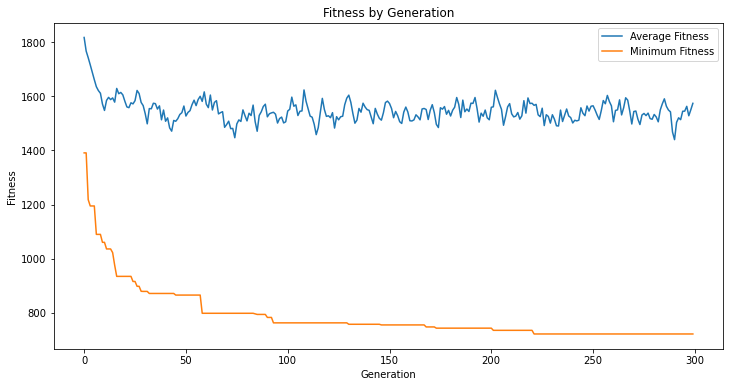

Excepted optimum: 511.253921
The optimum of my code: 721.7352382794342
vehicle 0:  [18, 17, 13, 14, 9, 7, 16, 15, 30, 12, 11, 8, 23, 19, 20]
vehicle 1:  [1, 5, 25, 24, 29, 35, 26, 28, 27, 22]
vehicle 2:  [21, 10]
vehicle 3:  [2, 4, 6, 3]


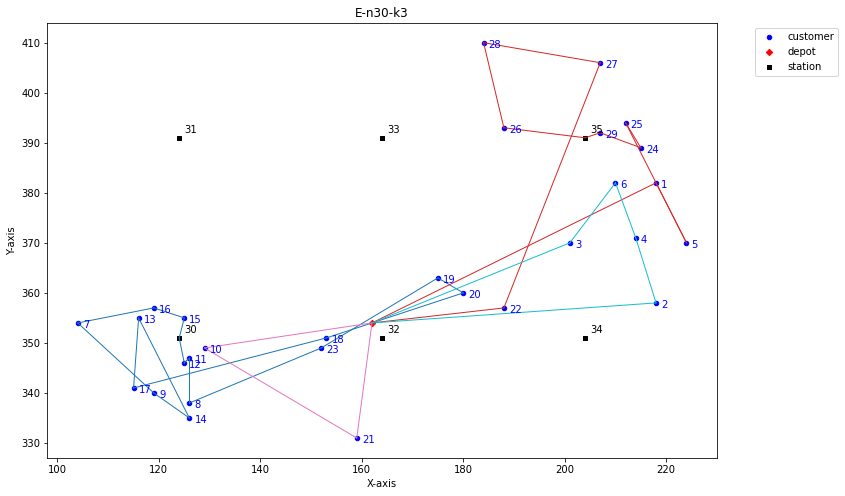




************************** E-n76-k7.evrp ****************************
----------------Start of evolution----------------


/data/home/exx866/.local/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/data/home/exx866/.local/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


  Evaluated 200 individuals
---- Generation 0 ----
  Evaluated 179 individuals
  Min 2537.315056543031
  Max 3164.3658191512855
  Avg 2858.937218583143
  Std 142.61342026747997
---- Generation 1 ----
  Evaluated 171 individuals
  Min 2478.1708641228342
  Max 3178.8051356453348
  Avg 2827.7057999437825
  Std 163.5835895474925
---- Generation 2 ----
  Evaluated 176 individuals
  Min 2478.1708641228342
  Max 3206.4003850153504
  Avg 2799.1394847207903
  Std 182.71028703292043
---- Generation 3 ----
  Evaluated 177 individuals
  Min 2359.718923645856
  Max 3206.4003850153504
  Avg 2770.874874751743
  Std 204.26746206198203
---- Generation 4 ----
  Evaluated 168 individuals
  Min 2316.953371365404
  Max 3206.4003850153504
  Avg 2747.1395622640966
  Std 217.5925474856358
---- Generation 5 ----
  Evaluated 163 individuals
  Min 2316.953371365404
  Max 3206.4003850153504
  Avg 2702.607993143804
  Std 223.8957295101929
---- Generation 6 ----
  Evaluated 158 individuals
  Min 2229.6319637557845


  Evaluated 174 individuals
  Min 1863.7919612432165
  Max 3225.5461692016493
  Avg 2574.336648043101
  Std 478.3841746492697
---- Generation 56 ----
  Evaluated 164 individuals
  Min 1863.7919612432165
  Max 3225.5461692016493
  Avg 2598.9249532252525
  Std 488.30048047299994
---- Generation 57 ----
  Evaluated 173 individuals
  Min 1863.7919612432165
  Max 3228.048979969065
  Avg 2540.602774777586
  Std 500.9329508915791
---- Generation 58 ----
  Evaluated 168 individuals
  Min 1863.7919612432165
  Max 3228.048979969065
  Avg 2550.894738722124
  Std 501.58020009646606
---- Generation 59 ----
  Evaluated 177 individuals
  Min 1863.7919612432165
  Max 3225.5461692016493
  Avg 2532.3324202925537
  Std 505.7550576430106
---- Generation 60 ----
  Evaluated 170 individuals
  Min 1863.7919612432165
  Max 3182.29118986858
  Avg 2474.5253669760364
  Std 498.87019950754893
---- Generation 61 ----
  Evaluated 177 individuals
  Min 1863.7919612432165
  Max 3158.718827909788
  Avg 2468.8961259888

  Evaluated 171 individuals
  Min 1710.666489460934
  Max 3155.9303697179957
  Avg 2463.6785241423627
  Std 532.6513506428419
---- Generation 111 ----
  Evaluated 177 individuals
  Min 1710.666489460934
  Max 3155.9303697179957
  Avg 2478.9715081152794
  Std 542.2395852662187
---- Generation 112 ----
  Evaluated 179 individuals
  Min 1710.666489460934
  Max 3184.1391488838226
  Avg 2512.249833912982
  Std 540.7758555134734
---- Generation 113 ----
  Evaluated 166 individuals
  Min 1701.9120750777483
  Max 3192.284706492366
  Avg 2542.929325928063
  Std 554.7524853718141
---- Generation 114 ----
  Evaluated 168 individuals
  Min 1701.9120750777483
  Max 3175.990028807102
  Avg 2506.2537234399597
  Std 576.432190219663
---- Generation 115 ----
  Evaluated 167 individuals
  Min 1701.9120750777483
  Max 3167.7581444333173
  Avg 2477.808899152514
  Std 581.8116080577998
---- Generation 116 ----
  Evaluated 183 individuals
  Min 1701.9120750777483
  Max 3247.587783442904
  Avg 2461.020247148

  Evaluated 181 individuals
  Min 1626.7820639826468
  Max 3257.5537836391054
  Avg 2426.97508308587
  Std 620.6424586691968
---- Generation 166 ----
  Evaluated 173 individuals
  Min 1626.7820639826468
  Max 3195.3184924130555
  Avg 2433.597735736343
  Std 619.4715040635506
---- Generation 167 ----
  Evaluated 165 individuals
  Min 1626.7820639826468
  Max 3208.3760509981216
  Avg 2407.02705493387
  Std 615.8331557251497
---- Generation 168 ----
  Evaluated 176 individuals
  Min 1626.7820639826468
  Max 3208.3760509981216
  Avg 2367.461945053614
  Std 607.7138014367756
---- Generation 169 ----
  Evaluated 179 individuals
  Min 1626.7820639826468
  Max 3245.752023518683
  Avg 2346.4526126432274
  Std 606.1674930132963
---- Generation 170 ----
  Evaluated 171 individuals
  Min 1626.7820639826468
  Max 3245.752023518683
  Avg 2357.085556680201
  Std 611.4162146541889
---- Generation 171 ----
  Evaluated 170 individuals
  Min 1626.7820639826468
  Max 3245.752023518683
  Avg 2409.334863897

  Evaluated 176 individuals
  Min 1602.457059931848
  Max 3274.9263305027876
  Avg 2426.20921615055
  Std 616.7104953398206
---- Generation 221 ----
  Evaluated 174 individuals
  Min 1602.457059931848
  Max 3274.9263305027876
  Avg 2510.994594518361
  Std 607.7738101418568
---- Generation 222 ----
  Evaluated 176 individuals
  Min 1602.457059931848
  Max 3274.9263305027876
  Avg 2473.853376145727
  Std 619.6485376977512
---- Generation 223 ----
  Evaluated 172 individuals
  Min 1602.457059931848
  Max 3174.7124231103226
  Avg 2473.0140128088715
  Std 595.9780086363859
---- Generation 224 ----
  Evaluated 173 individuals
  Min 1602.457059931848
  Max 3202.7029768607304
  Avg 2437.0632614857577
  Std 613.2322055087766
---- Generation 225 ----
  Evaluated 182 individuals
  Min 1602.457059931848
  Max 3202.7029768607304
  Avg 2373.5655771661773
  Std 624.7987826713206
---- Generation 226 ----
  Evaluated 180 individuals
  Min 1602.457059931848
  Max 3185.7125899961834
  Avg 2388.6719845274

  Evaluated 187 individuals
  Min 1596.4825821916652
  Max 3233.8024713228133
  Avg 2467.6899336914976
  Std 607.7942468529047
---- Generation 276 ----
  Evaluated 177 individuals
  Min 1596.4825821916652
  Max 3224.991086263654
  Avg 2460.742363701317
  Std 604.8494347260545
---- Generation 277 ----
  Evaluated 184 individuals
  Min 1596.4825821916652
  Max 3116.251109903307
  Avg 2434.3934015406203
  Std 601.7556561873613
---- Generation 278 ----
  Evaluated 159 individuals
  Min 1596.4825821916652
  Max 3271.014396545117
  Avg 2396.04466366556
  Std 621.946526398876
---- Generation 279 ----
  Evaluated 171 individuals
  Min 1596.4825821916652
  Max 3153.4135190772927
  Avg 2375.049837603104
  Std 643.2797819455278
---- Generation 280 ----
  Evaluated 160 individuals
  Min 1596.4825821916652
  Max 3246.903529101266
  Avg 2457.3807719258575
  Std 617.0758512623983
---- Generation 281 ----
  Evaluated 168 individuals
  Min 1596.4825821916652
  Max 3164.5503167401057
  Avg 2429.88378137

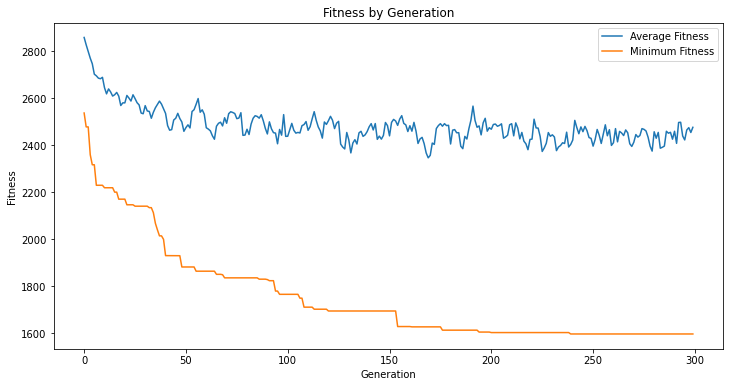

Excepted optimum: 723.367517
The optimum of my code: 1596.4825821916652
vehicle 0:  [2, 23, 41, 56, 42, 76, 74, 14, 84, 65, 66, 38, 58]
vehicle 1:  [46, 6, 48, 30, 27, 83, 52, 54, 25, 78, 18, 37, 82, 15, 19, 51]
vehicle 2:  [75, 33, 43, 1, 62, 16, 77, 24, 12, 34, 83, 29, 45]
vehicle 3:  [63, 73, 8, 83, 4, 9, 40, 10, 81, 31, 81, 70, 82, 57, 13]
vehicle 4:  [26, 17, 3, 49, 39, 81, 53, 35, 7, 50, 78, 55, 32, 72, 44, 77]
vehicle 5:  [28, 61, 36, 47, 82, 69, 21, 71, 60, 5, 82, 20, 68, 22, 76, 64]
vehicle 6:  [59, 11, 84, 67]


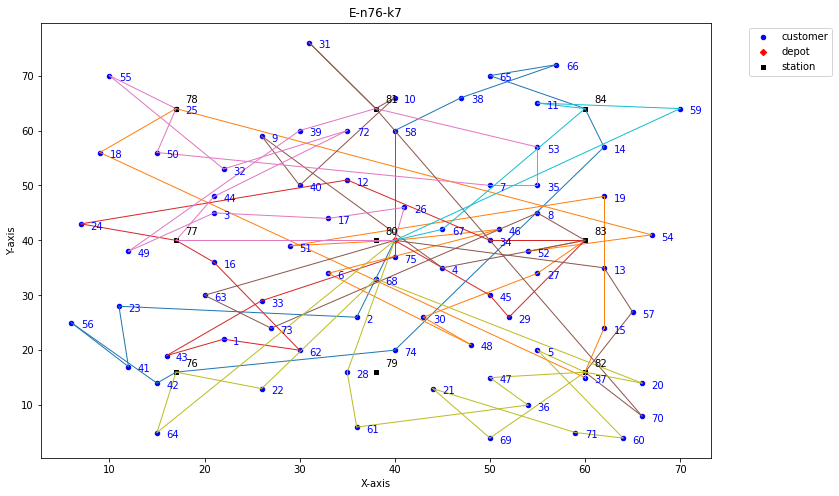




************************** E-n23-k3.evrp ****************************
----------------Start of evolution----------------
  Evaluated 200 individuals
---- Generation 0 ----
  Evaluated 164 individuals
  Min 1120.8408641072429
  Max 1783.447707358341
  Avg 1470.149661181903
  Std 142.06269643161414
---- Generation 1 ----


/data/home/exx866/.local/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/data/home/exx866/.local/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


  Evaluated 169 individuals
  Min 1120.8408641072429
  Max 1785.6205849625617
  Avg 1448.446410977166
  Std 158.05102212606735
---- Generation 2 ----
  Evaluated 175 individuals
  Min 1120.8408641072429
  Max 1777.6719327900148
  Avg 1423.4300021866445
  Std 175.44147891880252
---- Generation 3 ----
  Evaluated 172 individuals
  Min 1083.2502544602114
  Max 1777.6719327900148
  Avg 1406.4263102623593
  Std 192.26434722780152
---- Generation 4 ----
  Evaluated 178 individuals
  Min 1083.2502544602114
  Max 1777.6719327900148
  Avg 1392.347961566907
  Std 192.86413896293305
---- Generation 5 ----
  Evaluated 184 individuals
  Min 1083.2502544602114
  Max 1777.6719327900148
  Avg 1374.395730021821
  Std 198.22345872587542
---- Generation 6 ----
  Evaluated 169 individuals
  Min 1083.2502544602114
  Max 1777.6719327900148
  Avg 1359.2047266529612
  Std 196.4392624748995
---- Generation 7 ----
  Evaluated 169 individuals
  Min 1083.2502544602114
  Max 1733.6539042509048
  Avg 1364.735570129

  Evaluated 164 individuals
  Min 929.4406561813719
  Max 1763.430930580911
  Avg 1290.539219394547
  Std 296.5493384803284
---- Generation 59 ----
  Evaluated 167 individuals
  Min 929.4406561813719
  Max 1763.430930580911
  Avg 1323.4314959546589
  Std 299.1966006810364
---- Generation 60 ----
  Evaluated 157 individuals
  Min 929.4406561813719
  Max 1763.430930580911
  Avg 1318.6857358569675
  Std 282.56055425183433
---- Generation 61 ----
  Evaluated 170 individuals
  Min 926.1755136969774
  Max 1909.260248462814
  Avg 1301.9499586554634
  Std 291.35653607418055
---- Generation 62 ----
  Evaluated 169 individuals
  Min 926.1755136969774
  Max 1758.6227102882483
  Avg 1299.1077662053904
  Std 282.9625534425743
---- Generation 63 ----
  Evaluated 181 individuals
  Min 926.1755136969774
  Max 1722.2815163298885
  Avg 1280.6764419099966
  Std 285.1720197526019
---- Generation 64 ----
  Evaluated 175 individuals
  Min 926.1755136969774
  Max 1706.6393108363127
  Avg 1308.135198625501
  

  Evaluated 178 individuals
  Min 866.0732064332757
  Max 1782.9022661008937
  Avg 1309.6410733790478
  Std 299.4505507567924
---- Generation 115 ----
  Evaluated 175 individuals
  Min 866.0732064332757
  Max 1746.862526323337
  Avg 1275.8453809961568
  Std 300.6189332099104
---- Generation 116 ----
  Evaluated 166 individuals
  Min 866.0732064332757
  Max 1746.862526323337
  Avg 1288.4917223948942
  Std 304.0308076324749
---- Generation 117 ----
  Evaluated 180 individuals
  Min 866.0732064332757
  Max 1746.862526323337
  Avg 1298.8443641892163
  Std 298.34688883132014
---- Generation 118 ----
  Evaluated 157 individuals
  Min 866.0732064332757
  Max 1821.7351407075514
  Avg 1312.1906357939465
  Std 299.53238778738114
---- Generation 119 ----
  Evaluated 174 individuals
  Min 866.0732064332757
  Max 1738.3066575283015
  Avg 1318.4531079286496
  Std 300.0248624847854
---- Generation 120 ----
  Evaluated 175 individuals
  Min 866.0732064332757
  Max 1735.1113028154637
  Avg 1300.0280623

  Evaluated 181 individuals
  Min 778.4063421980768
  Max 1785.000838145551
  Avg 1248.0063860887537
  Std 335.5664161247313
---- Generation 171 ----
  Evaluated 181 individuals
  Min 778.4063421980768
  Max 1737.8389484408508
  Avg 1274.7194072985615
  Std 339.9013147888628
---- Generation 172 ----
  Evaluated 159 individuals
  Min 778.4063421980768
  Max 1801.70071538507
  Avg 1263.0742862211152
  Std 352.1637405591446
---- Generation 173 ----
  Evaluated 166 individuals
  Min 778.4063421980768
  Max 1801.70071538507
  Avg 1261.2037503675745
  Std 364.91374949975625
---- Generation 174 ----
  Evaluated 171 individuals
  Min 778.4063421980768
  Max 1836.7674457244277
  Avg 1275.14794225084
  Std 364.17246710301987
---- Generation 175 ----
  Evaluated 169 individuals
  Min 778.4063421980768
  Max 1836.7674457244277
  Avg 1292.4698312696858
  Std 352.3578270287658
---- Generation 176 ----
  Evaluated 176 individuals
  Min 778.4063421980768
  Max 1767.5022348254554
  Avg 1272.49178025148

  Evaluated 186 individuals
  Min 778.4063421980768
  Max 1747.4319125096551
  Avg 1294.8479200755996
  Std 352.59310083572615
---- Generation 228 ----
  Evaluated 178 individuals
  Min 778.4063421980768
  Max 1873.0773158510324
  Avg 1276.2638952174232
  Std 350.55597302243405
---- Generation 229 ----
  Evaluated 166 individuals
  Min 778.4063421980768
  Max 1798.2834084229262
  Avg 1310.0258874445294
  Std 347.0666312449091
---- Generation 230 ----
  Evaluated 164 individuals
  Min 778.4063421980768
  Max 1798.2834084229262
  Avg 1258.2725906451794
  Std 375.2594286550314
---- Generation 231 ----
  Evaluated 168 individuals
  Min 778.4063421980768
  Max 1794.0543981073508
  Avg 1254.652749671088
  Std 354.3875782988117
---- Generation 232 ----
  Evaluated 181 individuals
  Min 778.4063421980768
  Max 1794.0543981073508
  Avg 1240.66980832296
  Std 360.74441331764837
---- Generation 233 ----
  Evaluated 177 individuals
  Min 778.4063421980768
  Max 1784.5183032948523
  Avg 1245.227501

  Evaluated 171 individuals
  Min 758.9029681893276
  Max 1720.6841103714823
  Avg 1283.4786366461592
  Std 344.9583695203558
---- Generation 283 ----
  Evaluated 173 individuals
  Min 758.9029681893276
  Max 1795.7328103319776
  Avg 1296.09504226543
  Std 348.0958542329938
---- Generation 284 ----
  Evaluated 179 individuals
  Min 758.9029681893276
  Max 1723.2263352754044
  Avg 1260.3331131131076
  Std 355.46926020822747
---- Generation 285 ----
  Evaluated 182 individuals
  Min 758.9029681893276
  Max 1743.424338957681
  Avg 1275.6756277115926
  Std 356.1182837567454
---- Generation 286 ----
  Evaluated 171 individuals
  Min 758.9029681893276
  Max 1764.402687599122
  Avg 1265.856570962601
  Std 357.8738849017077
---- Generation 287 ----
  Evaluated 169 individuals
  Min 758.9029681893276
  Max 1817.3689431638152
  Avg 1262.1058653263578
  Std 366.0718633851001
---- Generation 288 ----
  Evaluated 174 individuals
  Min 758.9029681893276
  Max 1764.402687599122
  Avg 1270.49373013363

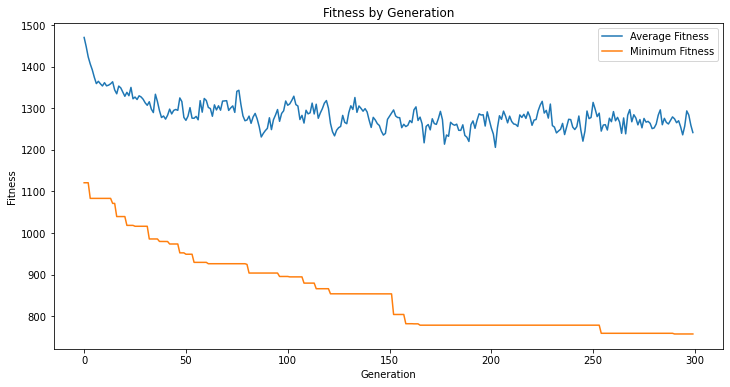

Excepted optimum: 573.130948
The optimum of my code: 757.264079259787
vehicle 0:  [3, 1, 6, 11, 12, 27, 18, 19, 21, 24, 7, 8, 4, 5, 9, 13]
vehicle 1:  [17, 15, 16, 2, 14, 30, 22, 20]
vehicle 2:  [10]


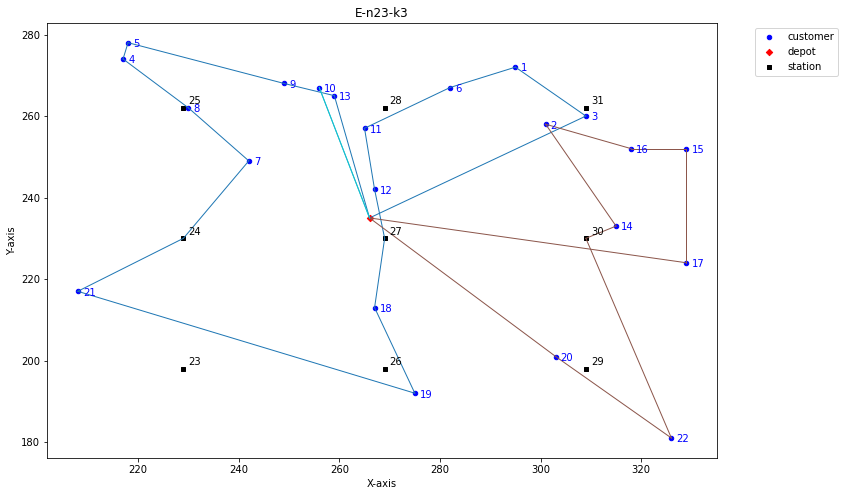




************************** E-n101-k8.evrp ****************************
----------------Start of evolution----------------


/data/home/exx866/.local/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/data/home/exx866/.local/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


  Evaluated 200 individuals
---- Generation 0 ----
  Evaluated 178 individuals
  Min 3472.5057054307003
  Max 4390.995665974018
  Avg 3896.2776192291767
  Std 192.13504406445145
---- Generation 1 ----
  Evaluated 186 individuals
  Min 3466.1138672111174
  Max 4338.21405843843
  Avg 3830.1346415449366
  Std 207.54722971312592
---- Generation 2 ----
  Evaluated 168 individuals
  Min 3421.6057353526407
  Max 4277.691050937616
  Avg 3786.8159120769824
  Std 227.38862733093936
---- Generation 3 ----
  Evaluated 172 individuals
  Min 3354.9193526775534
  Max 4218.837127825368
  Avg 3770.593789006989
  Std 238.62749257045039
---- Generation 4 ----
  Evaluated 175 individuals
  Min 3354.9193526775534
  Max 4231.044532060896
  Avg 3751.5993851047638
  Std 248.62055924645207
---- Generation 5 ----
  Evaluated 170 individuals
  Min 3354.9193526775534
  Max 4403.608236965912
  Avg 3751.6652707005064
  Std 265.4478856464169
---- Generation 6 ----
  Evaluated 173 individuals
  Min 3354.9193526775534

  Evaluated 166 individuals
  Min 2766.0990321234785
  Max 4371.2943838527635
  Avg 3444.409888725007
  Std 563.1732482160193
---- Generation 56 ----
  Evaluated 169 individuals
  Min 2766.0990321234785
  Max 4337.761084440202
  Avg 3517.397496098131
  Std 553.7735790833918
---- Generation 57 ----
  Evaluated 175 individuals
  Min 2766.0990321234785
  Max 4357.757169863025
  Avg 3488.708154764586
  Std 581.0534779304737
---- Generation 58 ----
  Evaluated 183 individuals
  Min 2766.0990321234785
  Max 4337.761084440202
  Avg 3504.5350367904944
  Std 576.582553436442
---- Generation 59 ----
  Evaluated 176 individuals
  Min 2766.0990321234785
  Max 4343.089866516373
  Avg 3481.9356492495367
  Std 579.3878547270069
---- Generation 60 ----
  Evaluated 173 individuals
  Min 2766.0990321234785
  Max 4343.089866516373
  Avg 3406.8740476548455
  Std 601.7029136566849
---- Generation 61 ----
  Evaluated 169 individuals
  Min 2766.0990321234785
  Max 4343.089866516373
  Avg 3488.309685142914
  

  Evaluated 164 individuals
  Min 2624.843227437472
  Max 4223.107515988166
  Avg 3412.3142721674108
  Std 602.2637506475427
---- Generation 111 ----
  Evaluated 175 individuals
  Min 2624.843227437472
  Max 4303.994859751146
  Avg 3405.1480540217476
  Std 618.7538144131828
---- Generation 112 ----
  Evaluated 183 individuals
  Min 2624.843227437472
  Max 4263.891011509602
  Avg 3364.312703275975
  Std 622.0378312760284
---- Generation 113 ----
  Evaluated 183 individuals
  Min 2624.843227437472
  Max 4367.818465731233
  Avg 3398.0447046481813
  Std 619.7040587807442
---- Generation 114 ----
  Evaluated 172 individuals
  Min 2624.843227437472
  Max 4367.396172310894
  Avg 3354.144494155361
  Std 638.330600185369
---- Generation 115 ----
  Evaluated 188 individuals
  Min 2624.843227437472
  Max 4367.396172310894
  Avg 3349.691357739382
  Std 631.1168428934877
---- Generation 116 ----
  Evaluated 179 individuals
  Min 2624.843227437472
  Max 4367.396172310894
  Avg 3400.7729259609105
  S

  Evaluated 172 individuals
  Min 2596.1654628832985
  Max 4320.81357677605
  Avg 3447.228984771484
  Std 574.452615046732
---- Generation 166 ----
  Evaluated 176 individuals
  Min 2596.1654628832985
  Max 4320.81357677605
  Avg 3435.358453783209
  Std 593.3146710218759
---- Generation 167 ----
  Evaluated 170 individuals
  Min 2596.1654628832985
  Max 4320.81357677605
  Avg 3433.7918656091397
  Std 590.6546562372994
---- Generation 168 ----
  Evaluated 165 individuals
  Min 2596.1654628832985
  Max 4297.642720743261
  Avg 3449.9697135037272
  Std 599.3799729722383
---- Generation 169 ----
  Evaluated 172 individuals
  Min 2596.1654628832985
  Max 4297.642720743261
  Avg 3434.0776417645266
  Std 608.4120701622845
---- Generation 170 ----
  Evaluated 175 individuals
  Min 2596.1654628832985
  Max 4297.642720743261
  Avg 3401.384119925333
  Std 642.2621245466053
---- Generation 171 ----
  Evaluated 168 individuals
  Min 2596.1654628832985
  Max 4392.125710849606
  Avg 3397.832679982707


  Evaluated 168 individuals
  Min 2596.1654628832985
  Max 4246.55629851071
  Avg 3364.455526623002
  Std 617.3341479974231
---- Generation 221 ----
  Evaluated 178 individuals
  Min 2596.1654628832985
  Max 4343.2027524937785
  Avg 3360.1214185489666
  Std 618.6261163958621
---- Generation 222 ----
  Evaluated 174 individuals
  Min 2596.1654628832985
  Max 4227.831723371727
  Avg 3349.77936324077
  Std 619.3642169571095
---- Generation 223 ----
  Evaluated 178 individuals
  Min 2596.1654628832985
  Max 4374.862076735312
  Avg 3343.5074206528766
  Std 606.4918023121314
---- Generation 224 ----
  Evaluated 165 individuals
  Min 2596.1654628832985
  Max 4374.862076735312
  Avg 3371.34942404191
  Std 615.3860322747263
---- Generation 225 ----
  Evaluated 176 individuals
  Min 2596.1654628832985
  Max 4374.862076735312
  Avg 3333.4051715624223
  Std 620.7384189834567
---- Generation 226 ----
  Evaluated 174 individuals
  Min 2596.1654628832985
  Max 4374.862076735312
  Avg 3346.37339086741

  Evaluated 178 individuals
  Min 2557.9210332407474
  Max 4289.348315491889
  Avg 3421.2572000795526
  Std 645.8944351843561
---- Generation 276 ----
  Evaluated 166 individuals
  Min 2557.9210332407474
  Max 4289.348315491889
  Avg 3426.1692530261607
  Std 650.5545737164375
---- Generation 277 ----
  Evaluated 155 individuals
  Min 2557.9210332407474
  Max 4278.437890318918
  Avg 3409.12357649984
  Std 649.5126381651477
---- Generation 278 ----
  Evaluated 176 individuals
  Min 2557.9210332407474
  Max 4237.229740536609
  Avg 3364.894851178741
  Std 650.5294032911406
---- Generation 279 ----
  Evaluated 173 individuals
  Min 2557.9210332407474
  Max 4362.407152989716
  Avg 3383.9142583337593
  Std 662.5661259370171
---- Generation 280 ----
  Evaluated 166 individuals
  Min 2557.9210332407474
  Max 4259.991204151984
  Avg 3412.69214168877
  Std 656.4953906334453
---- Generation 281 ----
  Evaluated 171 individuals
  Min 2557.9210332407474
  Max 4223.001839525267
  Avg 3364.55961973360

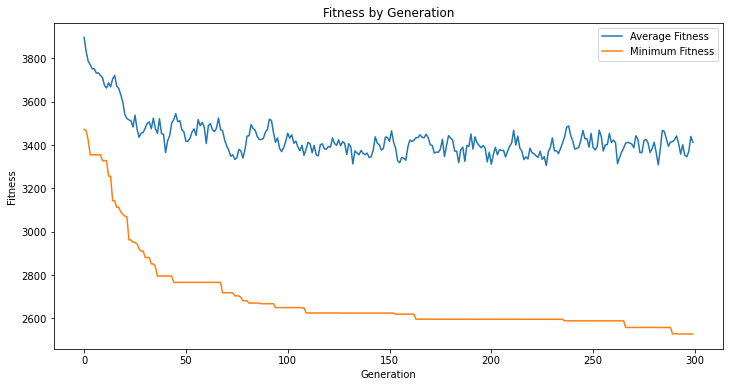

Excepted optimum: 899.885589
The optimum of my code: 2527.923921065248
vehicle 0:  [81, 68, 55, 54, 108, 3, 95, 57, 2, 104, 94, 69, 27, 40]
vehicle 1:  [16, 44, 86, 101, 39, 56, 107, 66, 109, 64, 90, 106, 46, 53, 105, 11, 32]
vehicle 2:  [52, 17, 98, 87, 104, 18, 31, 105, 34, 35, 77, 108, 89, 7, 48]
vehicle 3:  [59, 85, 91, 14, 37, 42, 101, 49, 103, 73, 104, 92, 15, 6, 8, 102, 74, 67, 107]
vehicle 4:  [12, 50, 29, 9, 71, 109, 79, 26, 41, 104, 43, 93, 100, 101, 62, 28]
vehicle 5:  [19, 60, 84, 102, 82, 83, 4, 75, 107, 5, 97, 104, 23, 22, 24, 80, 108, 33]
vehicle 6:  [21, 72, 51, 109, 88, 45, 102, 70, 1, 10, 106, 65, 78, 76, 108, 25, 58, 104, 38, 99, 96]
vehicle 7:  [47, 36, 103, 20, 30, 63, 106, 13, 61]


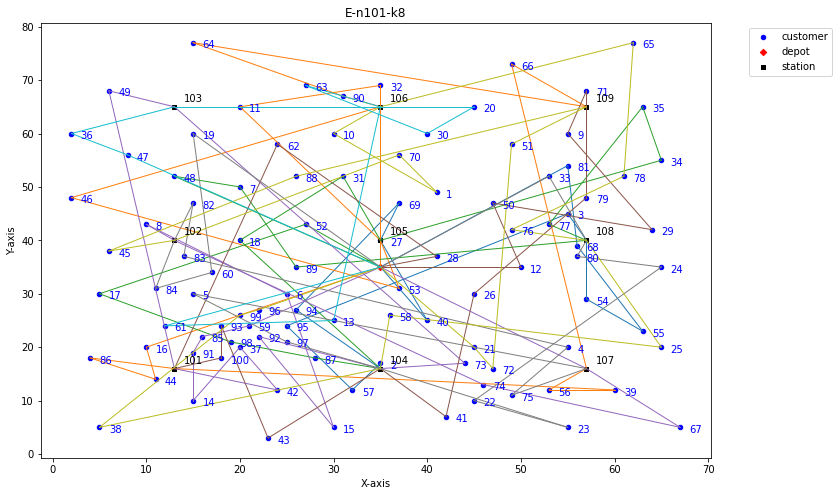




************************** E-n51-k5.evrp ****************************
----------------Start of evolution----------------
  Evaluated 200 individuals
---- Generation 0 ----


/data/home/exx866/.local/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/data/home/exx866/.local/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


  Evaluated 169 individuals
  Min 1556.5869332517168
  Max 2057.6989623806244
  Avg 1796.4275748193907
  Std 110.47758483957215
---- Generation 1 ----
  Evaluated 174 individuals
  Min 1547.2497784684988
  Max 2022.0654336344999
  Avg 1767.8927422315955
  Std 121.64884940148573
---- Generation 2 ----
  Evaluated 166 individuals
  Min 1532.6980379109402
  Max 2048.317315548597
  Avg 1751.426926162283
  Std 132.60158277606547
---- Generation 3 ----
  Evaluated 170 individuals
  Min 1532.6980379109402
  Max 2070.566943376329
  Avg 1745.7869437970842
  Std 141.6947599325794
---- Generation 4 ----
  Evaluated 177 individuals
  Min 1532.6980379109402
  Max 2070.566943376329
  Avg 1734.8977244967498
  Std 150.50402394112967
---- Generation 5 ----
  Evaluated 177 individuals
  Min 1450.2907815791216
  Max 2070.566943376329
  Avg 1722.680597732963
  Std 160.56093542899208
---- Generation 6 ----
  Evaluated 171 individuals
  Min 1450.2907815791216
  Max 2029.9034347791126
  Avg 1721.765527840937

  Min 1162.4365097835457
  Max 2020.320786112673
  Avg 1614.5811978647287
  Std 300.06293659371977
---- Generation 56 ----
  Evaluated 175 individuals
  Min 1162.4365097835457
  Max 2056.4832627765327
  Avg 1589.1266399383248
  Std 313.2502269073915
---- Generation 57 ----
  Evaluated 174 individuals
  Min 1162.4365097835457
  Max 2056.4832627765327
  Avg 1578.197163088324
  Std 313.7109016775998
---- Generation 58 ----
  Evaluated 178 individuals
  Min 1162.4365097835457
  Max 2056.4832627765327
  Avg 1594.916443563575
  Std 316.42922285599326
---- Generation 59 ----
  Evaluated 168 individuals
  Min 1162.4365097835457
  Max 2051.777190091109
  Avg 1614.838650400211
  Std 320.21930131077863
---- Generation 60 ----
  Evaluated 165 individuals
  Min 1162.4365097835457
  Max 2062.1049620351096
  Avg 1621.732246661736
  Std 318.5368216679844
---- Generation 61 ----
  Evaluated 182 individuals
  Min 1162.4365097835457
  Max 2108.2140157307194
  Avg 1626.8930621074262
  Std 327.457200704080

  Evaluated 179 individuals
  Min 1142.7542404133223
  Max 2119.6573051535124
  Avg 1576.7967913673328
  Std 332.9010949830811
---- Generation 112 ----
  Evaluated 174 individuals
  Min 1142.7542404133223
  Max 2032.860375866852
  Avg 1545.9260228364312
  Std 337.03639288652465
---- Generation 113 ----
  Evaluated 166 individuals
  Min 1142.7542404133223
  Max 2025.5265949446266
  Avg 1564.346508814412
  Std 342.73466141094417
---- Generation 114 ----
  Evaluated 182 individuals
  Min 1142.7542404133223
  Max 2035.9229144440787
  Avg 1577.304046569457
  Std 329.619264772251
---- Generation 115 ----
  Evaluated 167 individuals
  Min 1142.7542404133223
  Max 2057.468030574049
  Avg 1588.8102096130006
  Std 326.3136421088702
---- Generation 116 ----
  Evaluated 171 individuals
  Min 1142.7542404133223
  Max 2042.0082304635728
  Avg 1538.4964661705724
  Std 329.15096943259294
---- Generation 117 ----
  Evaluated 175 individuals
  Min 1142.7542404133223
  Max 2064.863425420615
  Avg 1570.69

  Evaluated 178 individuals
  Min 1137.3954376784075
  Max 2037.1169857980108
  Avg 1616.5385458132555
  Std 323.2156833185261
---- Generation 167 ----
  Evaluated 170 individuals
  Min 1137.3954376784075
  Max 2004.4226340476307
  Avg 1574.594336031811
  Std 331.83910086908946
---- Generation 168 ----
  Evaluated 170 individuals
  Min 1137.3954376784075
  Max 2025.3203366775365
  Avg 1569.1675438713098
  Std 332.68031070237316
---- Generation 169 ----
  Evaluated 185 individuals
  Min 1137.3954376784075
  Max 2066.5659551615668
  Avg 1568.5638219527482
  Std 333.0623182467124
---- Generation 170 ----
  Evaluated 181 individuals
  Min 1137.3954376784075
  Max 2113.162289940853
  Avg 1583.7309834055923
  Std 338.47910327726186
---- Generation 171 ----
  Evaluated 175 individuals
  Min 1137.3954376784075
  Max 2113.162289940853
  Avg 1584.187790633626
  Std 329.9645522252619
---- Generation 172 ----
  Evaluated 170 individuals
  Min 1137.3954376784075
  Max 2113.162289940853
  Avg 1576.6

  Evaluated 161 individuals
  Min 1104.6664097982048
  Max 2047.5287158214992
  Avg 1622.000896034225
  Std 355.3392662353698
---- Generation 221 ----
  Evaluated 178 individuals
  Min 1104.6664097982048
  Max 2047.5287158214992
  Avg 1609.500788563932
  Std 356.01301993425176
---- Generation 222 ----
  Evaluated 179 individuals
  Min 1104.6664097982048
  Max 2153.498065264711
  Avg 1604.9413359983473
  Std 354.27009822222743
---- Generation 223 ----
  Evaluated 186 individuals
  Min 1104.6664097982048
  Max 2153.498065264711
  Avg 1596.2673108260233
  Std 362.83327606310746
---- Generation 224 ----
  Evaluated 182 individuals
  Min 1104.6664097982048
  Max 2047.5287158214992
  Avg 1588.9097597742605
  Std 357.36402829978357
---- Generation 225 ----
  Evaluated 183 individuals
  Min 1104.6664097982048
  Max 2043.4630465713321
  Avg 1580.487281725578
  Std 356.73088250767444
---- Generation 226 ----
  Evaluated 158 individuals
  Min 1104.6664097982048
  Max 2082.8951443464175
  Avg 1566

  Min 1073.205746802278
  Max 2078.2661156759723
  Avg 1571.002858779807
  Std 361.41249495560857
---- Generation 276 ----
  Evaluated 168 individuals
  Min 1073.205746802278
  Max 2078.2661156759723
  Avg 1583.2013434547273
  Std 357.6194079211384
---- Generation 277 ----
  Evaluated 177 individuals
  Min 1073.205746802278
  Max 2003.1959931125407
  Avg 1562.0421525645395
  Std 359.5648231133452
---- Generation 278 ----
  Evaluated 184 individuals
  Min 1073.205746802278
  Max 2011.4560548266606
  Avg 1566.0916548801965
  Std 349.7914255473009
---- Generation 279 ----
  Evaluated 182 individuals
  Min 1073.205746802278
  Max 2011.4560548266606
  Avg 1560.4043031911635
  Std 360.4741772676471
---- Generation 280 ----
  Evaluated 176 individuals
  Min 1073.205746802278
  Max 2042.18590753492
  Avg 1557.2622043097651
  Std 360.9664740361052
---- Generation 281 ----
  Evaluated 170 individuals
  Min 1073.205746802278
  Max 2035.1707660540847
  Avg 1552.342991185721
  Std 375.2326465597601

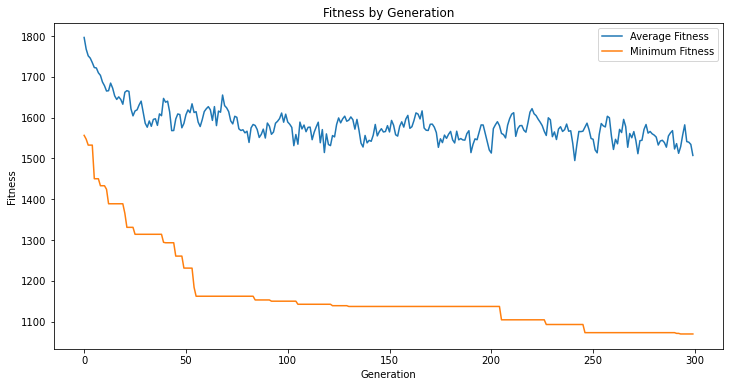

Excepted optimum: 570.170703
The optimum of my code: 1069.9681942580623
vehicle 0:  [11, 45, 33, 37, 54, 29, 35, 59, 46, 17, 15, 47]
vehicle 1:  [16, 38, 34, 49, 10, 39, 57, 21, 2, 8]
vehicle 2:  [6, 23, 24, 14, 52, 20, 36, 59, 32, 18]
vehicle 3:  [42, 44, 5, 55, 13, 40, 19, 41, 51, 25]
vehicle 4:  [48, 1, 26, 43, 7, 53, 3, 28, 31, 56, 30, 50, 9]
vehicle 5:  [12, 4, 27, 22]


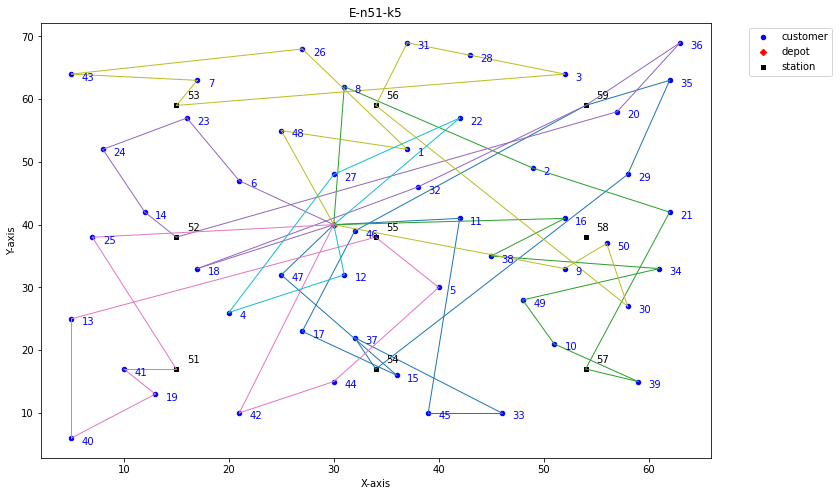




************************** E-n33-k4.evrp ****************************
----------------Start of evolution----------------
  Evaluated 200 individuals
---- Generation 0 ----
  Evaluated 172 individuals
  Min 1494.2966395634728
  Max 2084.671380876525
  Avg 1765.452395896299
  Std 136.990305406688
---- Generation 1 ----


/data/home/exx866/.local/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/data/home/exx866/.local/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


  Evaluated 178 individuals
  Min 1494.2966395634728
  Max 2125.075929143757
  Avg 1733.7916768147757
  Std 146.76208094496258
---- Generation 2 ----
  Evaluated 172 individuals
  Min 1409.8312454292259
  Max 2065.362661184688
  Avg 1722.2695709308014
  Std 157.08241307337158
---- Generation 3 ----
  Evaluated 176 individuals
  Min 1409.8312454292259
  Max 2110.0043005871253
  Avg 1710.3610691057575
  Std 161.19311983771715
---- Generation 4 ----
  Evaluated 175 individuals
  Min 1409.8312454292259
  Max 2110.0043005871253
  Avg 1719.016947412071
  Std 177.41384131019865
---- Generation 5 ----
  Evaluated 167 individuals
  Min 1409.8312454292259
  Max 2110.0043005871253
  Avg 1708.2352245068553
  Std 181.32874860021238
---- Generation 6 ----
  Evaluated 168 individuals
  Min 1372.139477705124
  Max 2056.1479308682715
  Avg 1671.430989239086
  Std 174.51850773837984
---- Generation 7 ----
  Evaluated 174 individuals
  Min 1371.3600004920047
  Max 2056.1479308682715
  Avg 1670.8423347899

  Evaluated 175 individuals
  Min 1185.5196246552339
  Max 2071.691418241051
  Avg 1554.3838062364712
  Std 304.13522684459076
---- Generation 59 ----
  Evaluated 168 individuals
  Min 1185.5196246552339
  Max 2075.3885995127403
  Avg 1569.3774575268203
  Std 302.952416902811
---- Generation 60 ----
  Evaluated 168 individuals
  Min 1185.5196246552339
  Max 2047.7639409706787
  Avg 1548.4793835861792
  Std 294.7254814402533
---- Generation 61 ----
  Evaluated 170 individuals
  Min 1185.5196246552339
  Max 2054.576841798322
  Avg 1521.1376296339033
  Std 304.77199043780644
---- Generation 62 ----
  Evaluated 169 individuals
  Min 1185.5196246552339
  Max 2064.4597757532765
  Avg 1519.1031901366773
  Std 303.5435787418712
---- Generation 63 ----
  Evaluated 173 individuals
  Min 1185.0945486471999
  Max 2180.1817618483637
  Avg 1553.8575350602664
  Std 304.3743256404563
---- Generation 64 ----
  Evaluated 178 individuals
  Min 1185.0945486471999
  Max 2180.1817618483637
  Avg 1551.733944

  Evaluated 172 individuals
  Min 1129.7119272151695
  Max 2112.1683984726333
  Avg 1543.063094064636
  Std 327.3026404691244
---- Generation 114 ----
  Evaluated 168 individuals
  Min 1129.7119272151695
  Max 2112.1683984726333
  Avg 1551.1249217482482
  Std 330.52563785312634
---- Generation 115 ----
  Evaluated 167 individuals
  Min 1129.7119272151695
  Max 2152.0378305515724
  Avg 1586.6883946769449
  Std 323.906313160786
---- Generation 116 ----
  Evaluated 179 individuals
  Min 1129.7119272151695
  Max 2069.09455505462
  Avg 1543.420459446491
  Std 333.46599343912226
---- Generation 117 ----
  Evaluated 174 individuals
  Min 1129.7119272151695
  Max 2161.1763964803417
  Avg 1517.2073294151926
  Std 326.75063665645195
---- Generation 118 ----
  Evaluated 169 individuals
  Min 1129.7119272151695
  Max 2089.887036845512
  Avg 1562.5341896012478
  Std 315.45712511616773
---- Generation 119 ----
  Evaluated 175 individuals
  Min 1129.7119272151695
  Max 2117.5369464425576
  Avg 1545.9

  Evaluated 164 individuals
  Min 1095.7528441506872
  Max 2047.3555470241786
  Avg 1528.5929582786746
  Std 353.02738387012386
---- Generation 169 ----
  Evaluated 183 individuals
  Min 1095.7528441506872
  Max 2131.662360821215
  Avg 1521.4519203152001
  Std 351.99261082288916
---- Generation 170 ----
  Evaluated 169 individuals
  Min 1095.7528441506872
  Max 2143.032464293161
  Avg 1532.168456161325
  Std 353.3152962225638
---- Generation 171 ----
  Evaluated 176 individuals
  Min 1095.7528441506872
  Max 2143.032464293161
  Avg 1543.1322571452913
  Std 359.3932725113767
---- Generation 172 ----
  Evaluated 171 individuals
  Min 1095.7528441506872
  Max 2143.032464293161
  Avg 1550.9776379995697
  Std 362.4565320384693
---- Generation 173 ----
  Evaluated 162 individuals
  Min 1095.7528441506872
  Max 2105.079618570884
  Avg 1542.7335529217116
  Std 354.92694063805857
---- Generation 174 ----
  Evaluated 188 individuals
  Min 1095.7528441506872
  Max 2092.130241293301
  Avg 1578.439

  Evaluated 176 individuals
  Min 1091.2869034612202
  Max 2146.049775739004
  Avg 1525.0954133654586
  Std 366.29164364520085
---- Generation 224 ----
  Evaluated 173 individuals
  Min 1091.2869034612202
  Max 2073.924843508346
  Avg 1523.095890226533
  Std 358.98174087971967
---- Generation 225 ----
  Evaluated 175 individuals
  Min 1091.2869034612202
  Max 2112.8515758257354
  Avg 1540.0663374950477
  Std 359.6336563107957
---- Generation 226 ----
  Evaluated 171 individuals
  Min 1090.3457847470986
  Max 2112.8515758257354
  Avg 1527.8379497919627
  Std 352.87346430218355
---- Generation 227 ----
  Evaluated 158 individuals
  Min 1090.3457847470986
  Max 2126.381470702924
  Avg 1524.4123048499116
  Std 355.77822564999576
---- Generation 228 ----
  Evaluated 170 individuals
  Min 1090.3457847470986
  Max 2126.381470702924
  Avg 1527.779437485632
  Std 361.68536689571846
---- Generation 229 ----
  Evaluated 174 individuals
  Min 1088.1641692068285
  Max 2126.381470702924
  Avg 1565.3

  Evaluated 165 individuals
  Min 1084.2395623566415
  Max 2164.1374596495343
  Avg 1533.4001001311688
  Std 361.6324776193217
---- Generation 279 ----
  Evaluated 168 individuals
  Min 1084.2395623566415
  Max 2164.1374596495343
  Avg 1558.6991739980263
  Std 357.76285588513923
---- Generation 280 ----
  Evaluated 176 individuals
  Min 1084.2395623566415
  Max 2164.1374596495343
  Avg 1585.1258221186647
  Std 352.37657249643235
---- Generation 281 ----
  Evaluated 175 individuals
  Min 1084.2395623566415
  Max 2139.4346548403905
  Avg 1560.0494932693196
  Std 360.7677774750613
---- Generation 282 ----
  Evaluated 169 individuals
  Min 1084.2395623566415
  Max 2112.909329437339
  Avg 1563.3971976421983
  Std 365.8249746839594
---- Generation 283 ----
  Evaluated 172 individuals
  Min 1084.2395623566415
  Max 2077.041048181173
  Avg 1552.6718699276798
  Std 361.60732940521865
---- Generation 284 ----
  Evaluated 177 individuals
  Min 1063.9720318226405
  Max 2163.2599614278065
  Avg 154

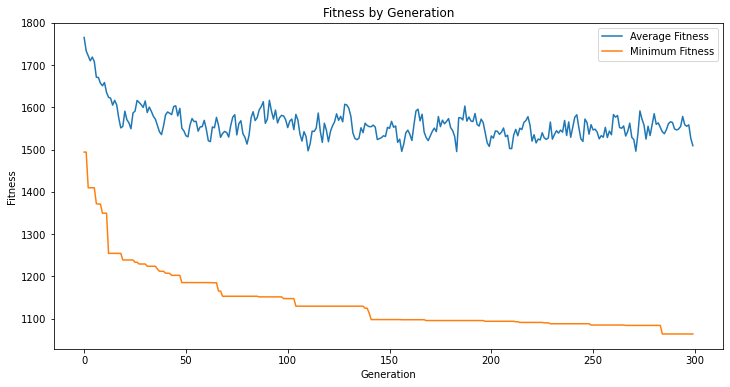

Excepted optimum: 869.892175
The optimum of my code: 1063.9720318226405
vehicle 0:  [3, 29, 16, 26, 33, 15, 13, 9, 10, 6]
vehicle 1:  [30, 19, 18, 25, 17, 31, 34, 12, 2]
vehicle 2:  [1, 14, 27, 28, 24, 36, 20, 23, 22, 21]
vehicle 3:  [4, 5, 11, 7, 8, 32, 37]


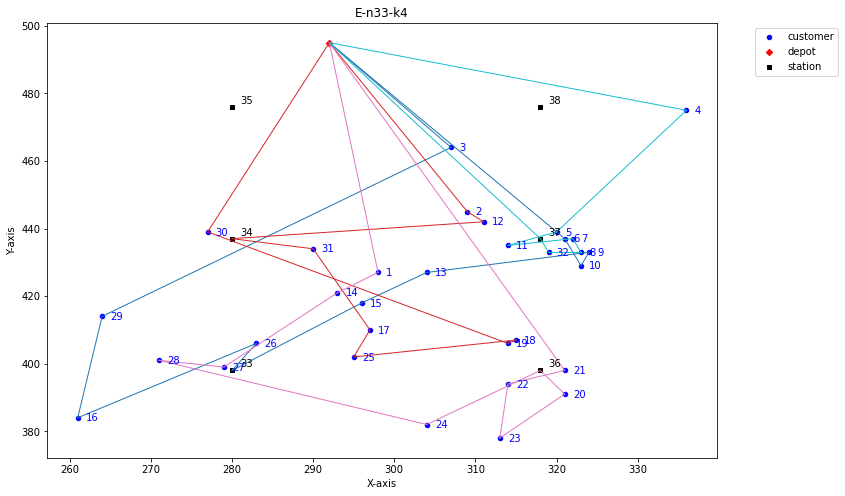




************************** E-n22-k4.evrp ****************************
----------------Start of evolution----------------
  Evaluated 200 individuals
---- Generation 0 ----
  Evaluated 168 individuals
  Min 681.7599714037453
  Max 1097.3518794864979
  Avg 892.8502478041368
  Std 88.54403840862618
---- Generation 1 ----


/data/home/exx866/.local/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/data/home/exx866/.local/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


  Evaluated 180 individuals
  Min 681.7599714037453
  Max 1070.9642029025729
  Avg 877.5940809654513
  Std 97.81002073242539
---- Generation 2 ----
  Evaluated 173 individuals
  Min 681.7599714037453
  Max 1070.9642029025729
  Avg 874.344818414339
  Std 106.00937915032873
---- Generation 3 ----
  Evaluated 165 individuals
  Min 681.7599714037453
  Max 1077.994953176337
  Avg 855.9470313039769
  Std 112.18815291274794
---- Generation 4 ----
  Evaluated 165 individuals
  Min 681.7599714037453
  Max 1077.994953176337
  Avg 833.2607548710474
  Std 117.30365510577839
---- Generation 5 ----
  Evaluated 179 individuals
  Min 681.7599714037453
  Max 1075.1094959159539
  Avg 824.6840669822876
  Std 119.97178118987232
---- Generation 6 ----
  Evaluated 169 individuals
  Min 681.7599714037453
  Max 1071.7987001954043
  Avg 827.2069891507956
  Std 127.17460166503072
---- Generation 7 ----
  Evaluated 173 individuals
  Min 649.571918645669
  Max 1074.5740770806804
  Avg 815.6990402629698
  Std 135.

  Min 571.3816878012523
  Max 1081.1093194589978
  Avg 811.7228356746401
  Std 169.0384276465016
---- Generation 59 ----
  Evaluated 173 individuals
  Min 571.3816878012523
  Max 1084.3416766042506
  Avg 794.9920412315427
  Std 186.93826240736496
---- Generation 60 ----
  Evaluated 179 individuals
  Min 571.3816878012523
  Max 1084.3416766042506
  Avg 800.0639940026416
  Std 181.63486026448518
---- Generation 61 ----
  Evaluated 181 individuals
  Min 565.0765191029473
  Max 1100.298357431617
  Avg 823.3511833335957
  Std 179.97715502161557
---- Generation 62 ----
  Evaluated 164 individuals
  Min 565.0765191029473
  Max 1099.6286635703545
  Avg 795.8976273990321
  Std 181.13126307720574
---- Generation 63 ----
  Evaluated 173 individuals
  Min 565.0765191029473
  Max 1102.5267001895138
  Avg 791.7595978224666
  Std 177.71769131932317
---- Generation 64 ----
  Evaluated 165 individuals
  Min 565.0765191029473
  Max 1125.4727848683826
  Avg 770.6449171515835
  Std 182.49090122197683
----

  Min 557.9660756740597
  Max 1067.9281830741636
  Avg 805.2788127692766
  Std 181.71028919444018
---- Generation 114 ----
  Evaluated 174 individuals
  Min 557.9660756740597
  Max 1089.8297676042203
  Avg 800.1038858094574
  Std 188.5792736471138
---- Generation 115 ----
  Evaluated 178 individuals
  Min 557.9660756740597
  Max 1089.8297676042203
  Avg 779.3491137652137
  Std 184.95404083525193
---- Generation 116 ----
  Evaluated 175 individuals
  Min 557.9660756740597
  Max 1074.6373219109616
  Avg 766.558328197069
  Std 176.36960866442698
---- Generation 117 ----
  Evaluated 168 individuals
  Min 557.9660756740597
  Max 1074.6373219109616
  Avg 777.1861280951433
  Std 184.44748232238493
---- Generation 118 ----
  Evaluated 159 individuals
  Min 557.9660756740597
  Max 1087.1526728366823
  Avg 786.7517557164501
  Std 186.76837380965102
---- Generation 119 ----
  Evaluated 174 individuals
  Min 557.9660756740597
  Max 1092.7966007968942
  Avg 792.676778771914
  Std 188.8565028010258


  Evaluated 165 individuals
  Min 541.4488987000029
  Max 1062.493952669925
  Avg 774.8097097787719
  Std 187.87042849565094
---- Generation 169 ----
  Evaluated 174 individuals
  Min 541.4488987000029
  Max 1123.5206870377908
  Avg 789.3523115681742
  Std 188.0992405015204
---- Generation 170 ----
  Evaluated 180 individuals
  Min 541.4488987000029
  Max 1123.5206870377908
  Avg 799.556884465843
  Std 184.99172622234568
---- Generation 171 ----
  Evaluated 177 individuals
  Min 541.4488987000029
  Max 1128.7625429161653
  Avg 808.172719924246
  Std 182.94754121979653
---- Generation 172 ----
  Evaluated 179 individuals
  Min 541.4488987000029
  Max 1119.9065852986455
  Avg 801.6280845127518
  Std 191.98901657651646
---- Generation 173 ----
  Evaluated 183 individuals
  Min 541.4488987000029
  Max 1119.9065852986455
  Avg 793.5745847553295
  Std 195.52446614496122
---- Generation 174 ----
  Evaluated 172 individuals
  Min 541.4488987000029
  Max 1066.7938447173356
  Avg 810.47818857088

  Evaluated 180 individuals
  Min 541.4488987000029
  Max 1106.1518037769058
  Avg 818.5368211213321
  Std 186.97427043735323
---- Generation 224 ----
  Evaluated 168 individuals
  Min 541.4488987000029
  Max 1119.6874380588438
  Avg 804.8964924654017
  Std 200.62745931771354
---- Generation 225 ----
  Evaluated 175 individuals
  Min 541.4488987000029
  Max 1118.892552299615
  Avg 790.2581073076608
  Std 200.75324856096438
---- Generation 226 ----
  Evaluated 178 individuals
  Min 541.4488987000029
  Max 1106.1518037769058
  Avg 788.0688664751083
  Std 202.15987080854669
---- Generation 227 ----
  Evaluated 171 individuals
  Min 541.4488987000029
  Max 1106.1518037769058
  Avg 806.1247980229132
  Std 189.72763720675695
---- Generation 228 ----
  Evaluated 181 individuals
  Min 541.4488987000029
  Max 1106.1518037769058
  Avg 793.0350160253471
  Std 196.27335707833114
---- Generation 229 ----
  Evaluated 176 individuals
  Min 541.4488987000029
  Max 1083.766422385626
  Avg 794.471734734

  Evaluated 175 individuals
  Min 541.4488987000029
  Max 1115.544245196796
  Avg 822.3343809048896
  Std 188.254392026654
---- Generation 280 ----
  Evaluated 178 individuals
  Min 541.4488987000029
  Max 1115.544245196796
  Avg 803.9426623291312
  Std 187.33182263247932
---- Generation 281 ----
  Evaluated 159 individuals
  Min 541.4488987000029
  Max 1115.544245196796
  Avg 779.4580415464821
  Std 183.2780966511252
---- Generation 282 ----
  Evaluated 182 individuals
  Min 541.4488987000029
  Max 1115.544245196796
  Avg 781.043288424042
  Std 194.27522488869712
---- Generation 283 ----
  Evaluated 178 individuals
  Min 541.4488987000029
  Max 1115.544245196796
  Avg 789.8381536622248
  Std 194.47687657601972
---- Generation 284 ----
  Evaluated 174 individuals
  Min 541.4488987000029
  Max 1142.2158853370627
  Avg 790.3608770900937
  Std 195.9109080416934
---- Generation 285 ----
  Evaluated 173 individuals
  Min 541.4488987000029
  Max 1142.2158853370627
  Avg 777.9532327655742
  S

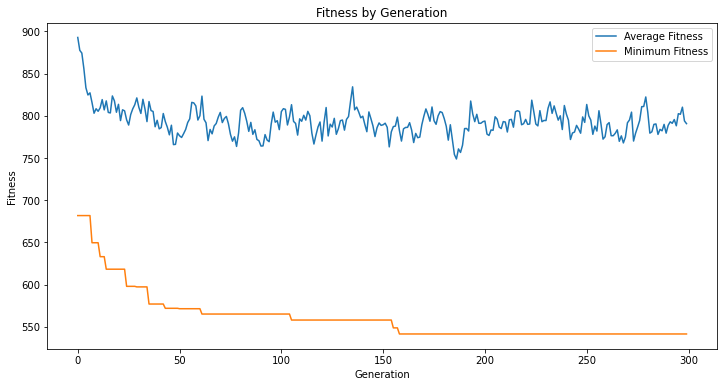

Excepted optimum: 384.678035
The optimum of my code: 541.4488987000029
vehicle 0:  [12, 7, 2, 29, 6, 16]
vehicle 1:  [13, 19, 20, 26]
vehicle 2:  [4, 3, 1, 29, 5, 10]
vehicle 3:  [11, 8, 9, 28, 14, 21, 17, 26, 18, 15]


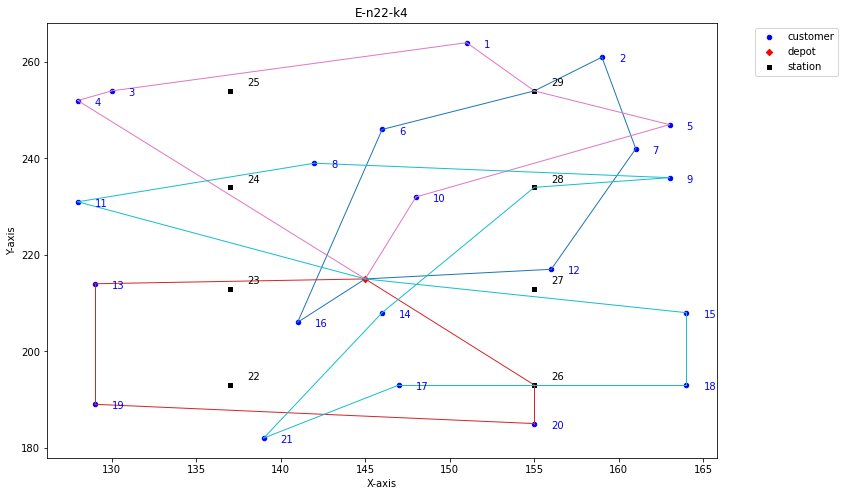

In [47]:
small_scale_instances = fnmatch.filter(os.listdir(data_dir), 'E*.evrp')

seed = 1
pop_size = 200
n_gen = 300
rate_elite = 0.2
cx_prob = 0.85
mut_prob = 0.1
immig_prop = 0.2

for instance_name in small_scale_instances:
    
    print(end='\n\n\n')
    print(f'************************** {instance_name} ****************************')
    best_ind, routes, fitness, run_file = run_ga(instance_name, seed, pop_size, n_gen, rate_elite, 
                                   cx_prob, mut_prob, immig_prop, export_csv=True)
    instance = Benchmark_Instance(os.path.join(data_dir, instance_name))
    df = create_dataframe(instance)

    df_run = pd.read_csv(run_file)
    plot_fitness_graph(df_run)

    print(f'Excepted optimum: {instance.optimum}')
    print(f'The optimum of my code: {fitness}')

    for idx, route in enumerate(routes):
        print(f'vehicle {idx}: ', route)
    visualize_routes(routes, df, instance.name)

In [48]:
large_scale_instances = fnmatch.filter(os.listdir(data_dir), 'X*.evrp')

seed = 1
pop_size = 200
n_gen = 300
rate_elite = 0.2
cx_prob = 0.85
mut_prob = 0.1
immig_prop = 0.2

for instance_name in large_scale_instances:
    
    print(end='\n\n\n')
    print(f'************************** {instance_name} ****************************')
    best_ind, routes, fitness, run_file = run_ga(instance_name, seed, pop_size, n_gen, rate_elite, 
                                   cx_prob, mut_prob, immig_prop, export_csv=True)
    instance = Benchmark_Instance(os.path.join(data_dir, instance_name))
    df = create_dataframe(instance)

    df_run = pd.read_csv(run_file)
    plot_fitness_graph(df_run)

    print(f'Excepted optimum: {instance.optimum}')
    print(f'The optimum of my code: {fitness}')

    for idx, route in enumerate(routes):
        print(f'vehicle {idx}: ', route)
    visualize_routes(routes, df, instance.name)




************************** X-n685-k75.evrp ****************************


/data/home/exx866/.local/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/data/home/exx866/.local/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


----------------Start of evolution----------------
  Evaluated 200 individuals
---- Generation 0 ----
  Evaluated 168 individuals
  Min 371633.22087125643
  Max 409669.3411521036
  Avg 390929.7582558771
  Std 6736.537894070536
---- Generation 1 ----
  Evaluated 164 individuals
  Min 371633.22087125643
  Max 409669.3411521036
  Avg 390649.6805466415
  Std 7277.550728009725
---- Generation 2 ----
  Evaluated 168 individuals


KeyboardInterrupt: 

### Validate the genetic operators

In [19]:
creator.create('FitnessMin', base.Fitness, weights=(-1.0, ))
creator.create('Individual', list, fitness=creator.FitnessMin)

In [58]:
random.seed(2)

# ind_size = instance.dimension - 1
ind_size = 8
pop_size = 5

toolbox = base.Toolbox()

toolbox.register('indexes', random.sample, range(1, ind_size + 1), ind_size)
toolbox.register('individual', tools.initIterate, creator.Individual, toolbox.indexes)
toolbox.register('population', tools.initRepeat, list, toolbox.individual, n=pop_size)
toolbox.register('evaluate', fitness_evaluation, instance=instance)

pop = toolbox.population()

print(f'-------Initialized Population with {pop_size} Individuals-----------')
fitnesses = list(map(toolbox.evaluate, pop))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit
    print(ind, ind.fitness.values)

print()
print(f'----------- Select -----------')
num_elites = math.floor(0.2 * len(pop))
toolbox.register('select_01', tools.selBest, k=num_elites)
elites = toolbox.select_01(pop)
print(f'Select Strategy (  Best  ) & Selection number {num_elites}:')
[print(f'  {x}') for x in elites]

toolbox.register('select_02', tools.selRoulette)
num_selection = 3
print(f'Select Strategy (Roulette) & Selection number {num_selection}:')
selected = toolbox.select_02(pop, k=num_selection)
[print(f'  {x}') for x in selected]

toolbox.register('select_03', selection, rate=0.4)
print(f'Select Strategy ( Custom ) & Selection number {num_selection}:')
selected = toolbox.select_03(pop, num_selection)
[print(f'  {x}') for x in selected]



print()
print(f'------------ Other deap toolbox components ---------------')

print('  Before Clone:')
[print(ind) for ind in pop]
pop_clone = list(map(toolbox.clone, pop))
print('  After Clone :')
[print(ind) for ind in pop_clone]




print()
print('----------- Mate (Crossover) -----------')
toolbox.register('mate', cx_partialy_matched)
print('  Before Mating:')
print(pop_clone[0])
print(pop_clone[1])
print('  After Mating :')
offspring1, offspring2 = toolbox.mate(pop_clone[0], pop_clone[1])
print(pop_clone[0])
print(pop_clone[1])


print()
print('------------ Mutation -------------')
prob = 0.3
toolbox.register('mutate', tools.mutShuffleIndexes, indpb=prob)
print('  Before Mutate:')
print(pop_clone[-1])
mutated = toolbox.mutate(pop_clone[-1])
print('  After Mutate :')
print(pop_clone[-1])


print()
print('------------ ------ -------------')
print('  Before:')
for ind in pop:
    print(ind)
print('  After :')
for ind in pop_clone:
    print(ind)


-------Initialized Population with 5 Individuals-----------
[1, 8, 7, 3, 2, 5, 4, 6] (305.02421999345415,)
[4, 5, 1, 7, 2, 8, 3, 6] (316.9603579214401,)
[8, 5, 3, 1, 7, 2, 6, 4] (322.2207772632087,)
[7, 4, 5, 2, 6, 1, 3, 8] (303.64218092092506,)
[3, 8, 2, 6, 7, 4, 1, 5] (292.38790948285606,)

----------- Select -----------
Select Strategy (  Best  ) & Selection number 1:
  [3, 8, 2, 6, 7, 4, 1, 5]
Select Strategy (Roulette) & Selection number 3:
  [8, 5, 3, 1, 7, 2, 6, 4]
  [4, 5, 1, 7, 2, 8, 3, 6]
  [8, 5, 3, 1, 7, 2, 6, 4]
Select Strategy ( Custom ) & Selection number 3:
  [3, 8, 2, 6, 7, 4, 1, 5]
  [4, 5, 1, 7, 2, 8, 3, 6]
  [4, 5, 1, 7, 2, 8, 3, 6]

------------ Other deap toolbox components ---------------
  Before Clone:
[1, 8, 7, 3, 2, 5, 4, 6]
[4, 5, 1, 7, 2, 8, 3, 6]
[8, 5, 3, 1, 7, 2, 6, 4]
[7, 4, 5, 2, 6, 1, 3, 8]
[3, 8, 2, 6, 7, 4, 1, 5]
  After Clone :
[1, 8, 7, 3, 2, 5, 4, 6]
[4, 5, 1, 7, 2, 8, 3, 6]
[8, 5, 3, 1, 7, 2, 6, 4]
[7, 4, 5, 2, 6, 1, 3, 8]
[3, 8, 2, 6, 7, 4, 1, 